# SIRD

**NB:** Set the argument `output_image` of the plotting functions to `False` when running the notebook to have interactive plots (some have a dropdown that allows to choose the province/region)

In [1]:
import pandas as pd
import numpy as np
import datetime

from scipy.integrate import odeint

import lmfit

from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from plots import *
from utils import *
from sird import *

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, dpc_province_df, pop_prov_df, prov_list_df = load_data(data_path)

## Basic SIRD
Stochastic and continuous with logistic Rt

In [5]:
province = 'Firenze'

sirsol = sird(province, pop_prov_df)
S, I, R, D = sirsol

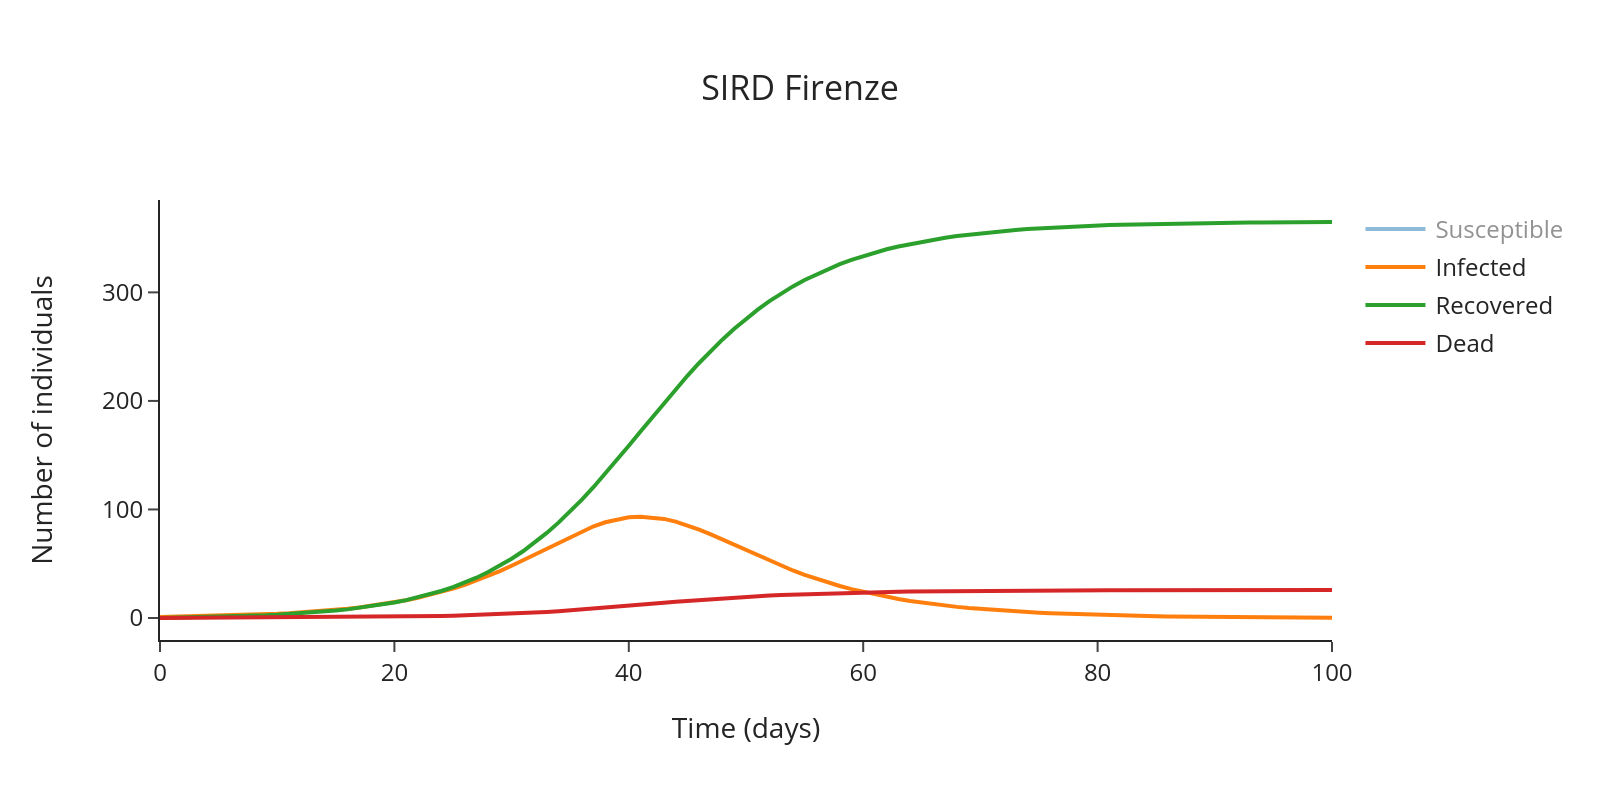

In [6]:
times = list(range(sirsol.shape[1]))

general_plot(t=times, 
             data=sirsol, 
             title='SIRD ' + province,
             traces_visibility=['legendonly'] + [True]*3,
             output_image=True,
             template='simple_white')

In [7]:
# Uncomment for interactive plots

#result = pd.DataFrame()
#for prov in covidpro_df.Province.unique():
#    S, I, R, D = sird(prov, pop_prov_df)
#    tmp = pd.DataFrame(np.column_stack([[prov]*len(S),range(len(S)),S,I,R,D]))
#    result = pd.concat([result, tmp])
#    
#result.columns = ["Province", "t", "S", "I", "R", "D"]
#result.reset_index(drop=True,inplace=True)

In [8]:
#inter_dropdown_plot(options=result.Province.unique(), 
#                    default_value='Firenze', 
#                    dropdown_label='Province',
#                    y=["S", "I", "R", "D"],
#                    legend_titles=['Susceptible', 'Infected', 'Recovered', 'Dead'],
#                    data=result,
#                    group_column='Province',
#                    x='t',
#                    title='COVID-19 trendlines of ',
#                    xtitle='Data',
#                    ytitle='Unità',
#                    traces_visibility=['legendonly',True,True,True],
#                    output_image=False)

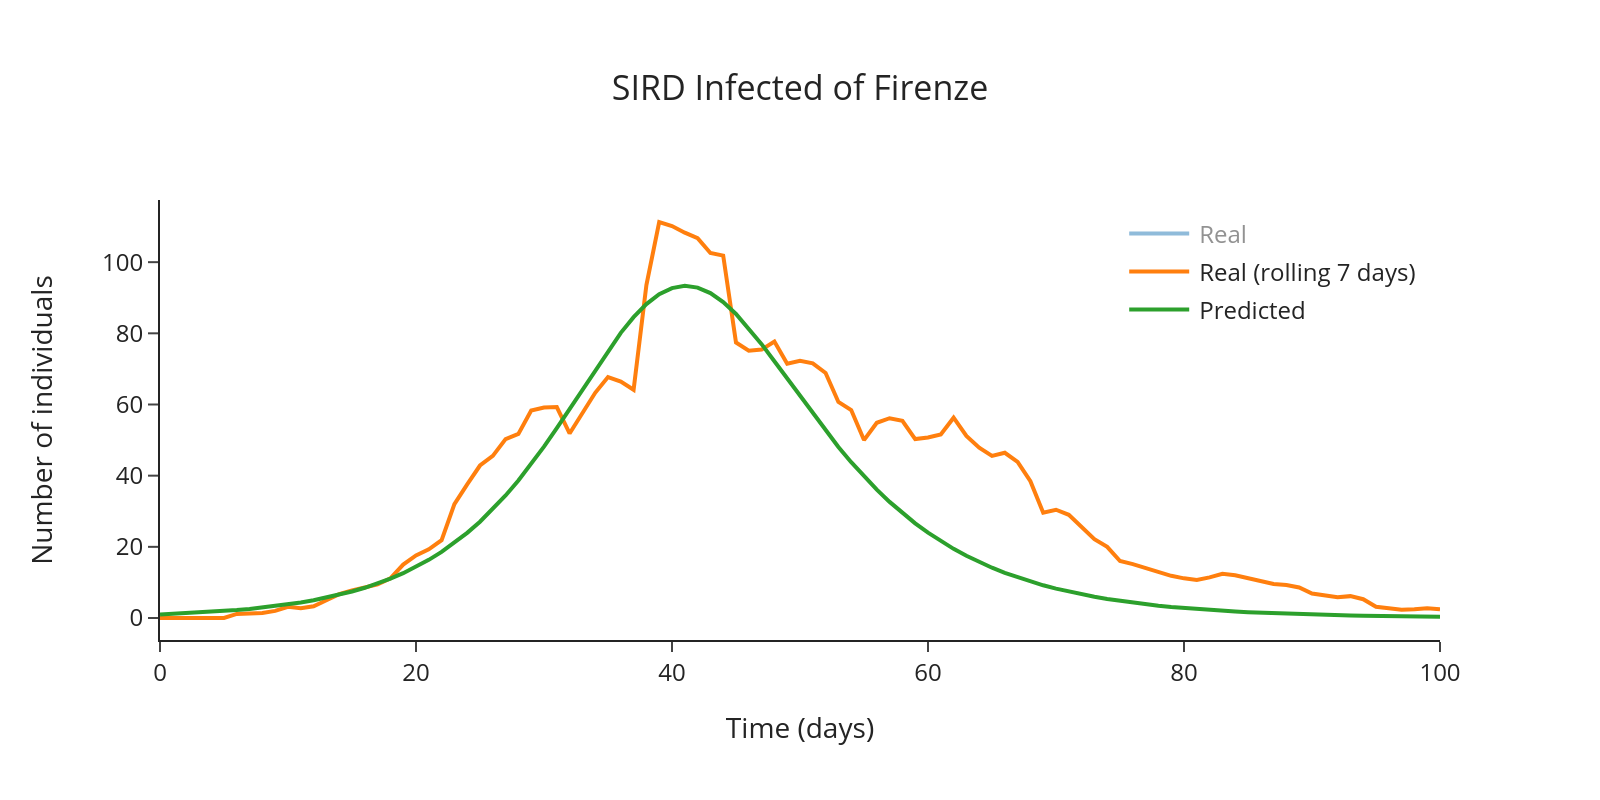

In [9]:
names, title, data, modes = data_for_plot('Infected', covidpro_df, 'New_cases', I, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True],
             template='simple_white')

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [11]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(10.684018260735181, 198.36702622348741)

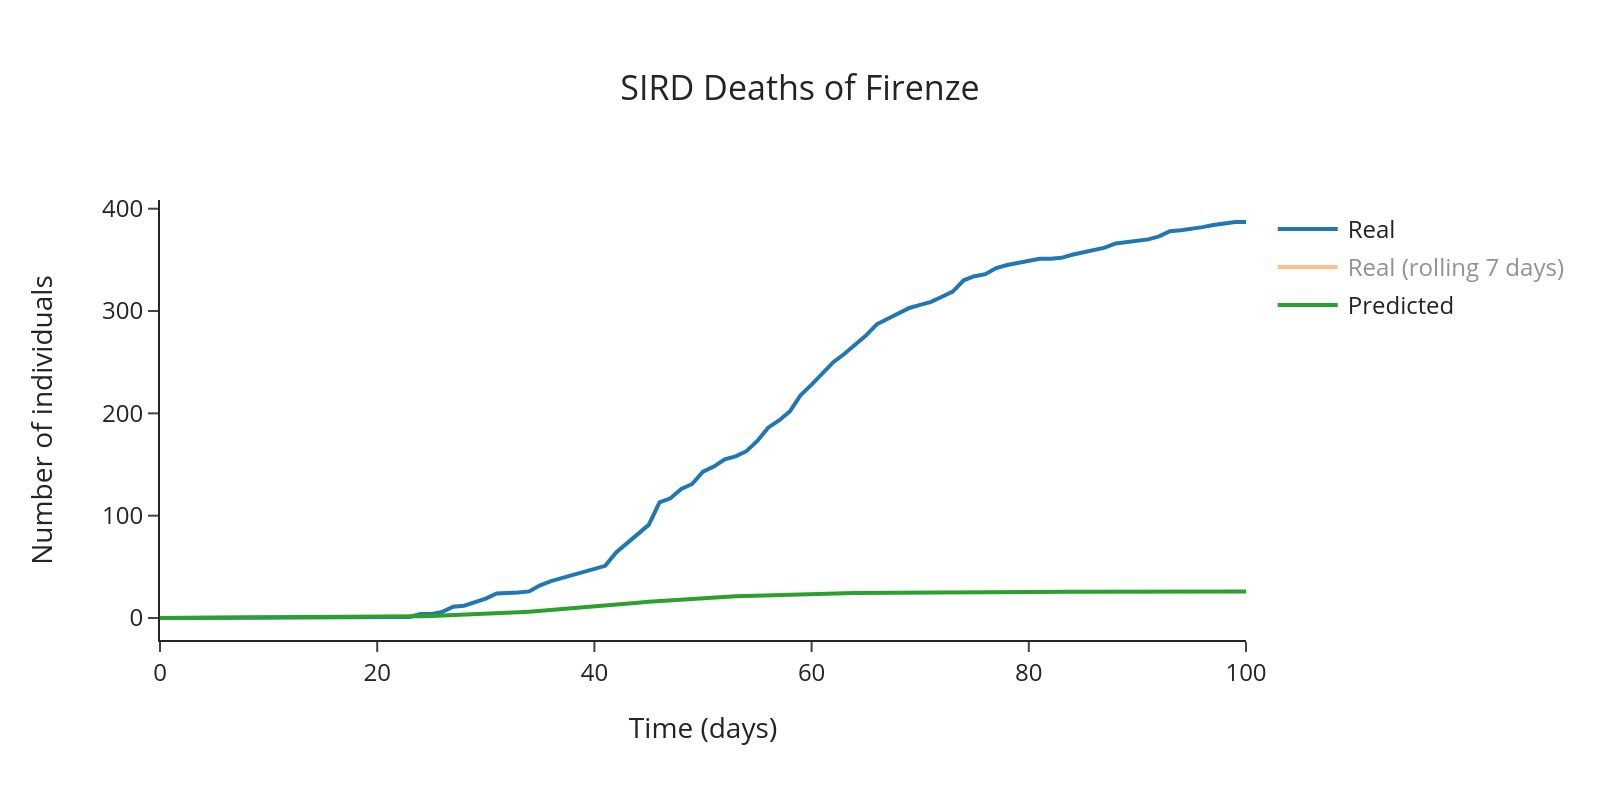

In [12]:
names, title, data, modes = data_for_plot('Deaths', covidpro_df, 'Tot_deaths', D, province)

general_plot(t=times,
             title=title,
             data=data, 
             names=names,
             modes=modes,
             blend_legend=False,
             output_image=True,
             traces_visibility=[True,'legendonly',True],
             template='simple_white')

In [13]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(139.55227138835534, 38606.3719889688)

In [14]:
result = pd.DataFrame()
for prov in covidpro_df.Province.unique():
    _, I, _, _ = sird(prov, pop_prov_df)
    names, _, data, _ = data_for_plot('Infected', covidpro_df, 'New_cases', I, prov)
    tmp = pd.DataFrame(np.column_stack([[prov]*data[2].shape[0],range(data[2].shape[0]),data[0],data[1],data[2]]))
    result = pd.concat([result, tmp])
    
result.columns = ["Province", "t", "real", "real_roll", "pred"]
result.reset_index(drop=True,inplace=True)

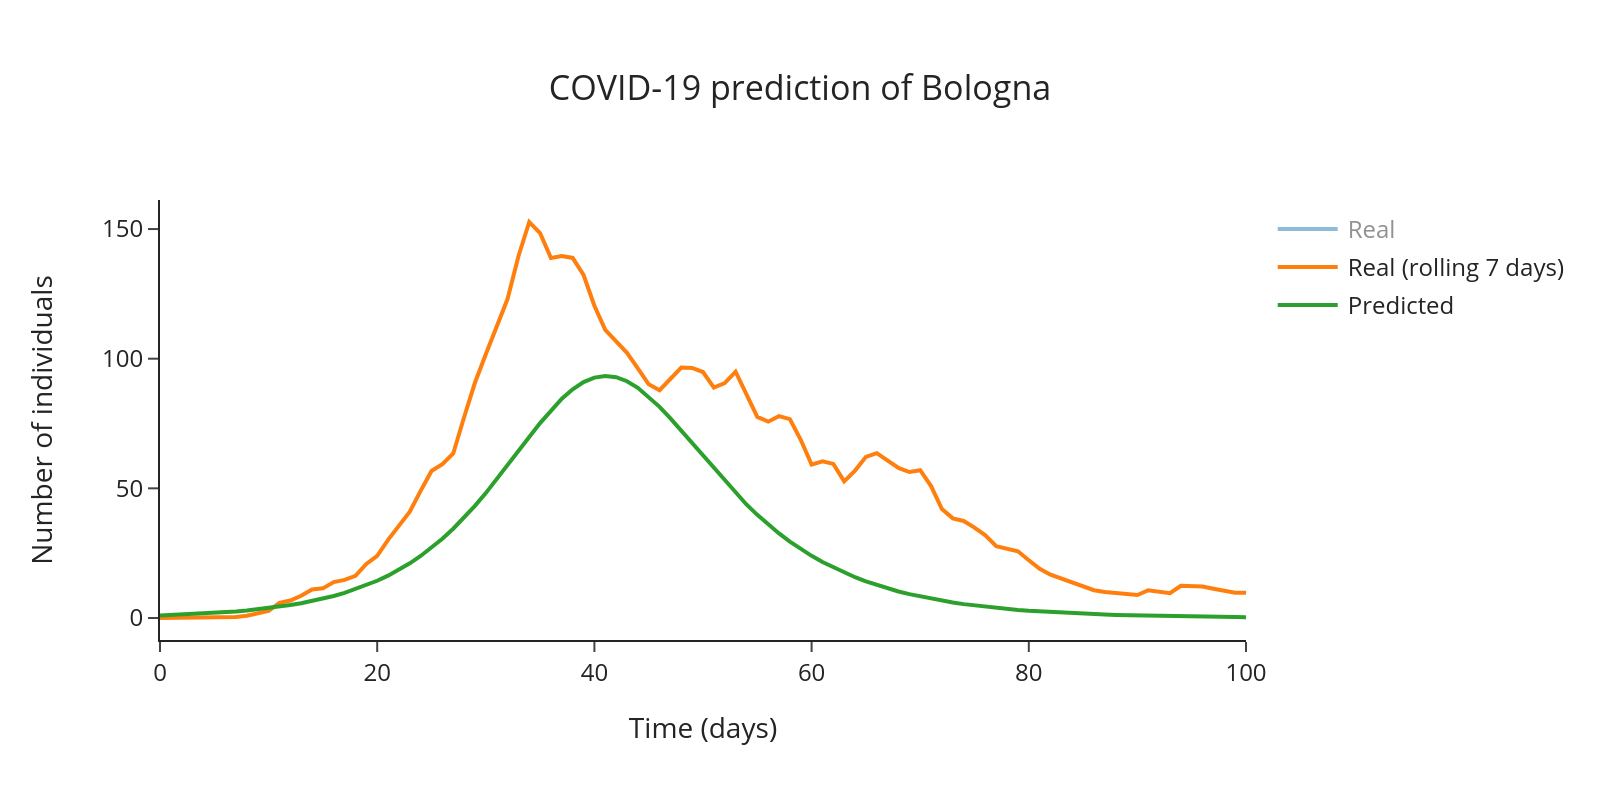

In [15]:
inter_dropdown_plot(options=result.Province.unique(), 
                    default_value='Bologna', 
                    dropdown_label='Province',
                    y=["real", "real_roll", "pred"],
                    legend_titles=names,
                    data=result,
                    group_column='Province',
                    x='t',
                    title='COVID-19 prediction of ',
                    xtitle='Time (days)',
                    ytitle='Number of individuals',
                    output_image=True,
                    traces_visibility=['legendonly',True,True],
                    template='simple_white')

In [16]:
mean_absolute_error(result['real_roll'], result['pred']), mean_squared_error(result['real_roll'], result['pred'])

(20.671333591115857, 1242.7771052357236)

## Parameter estimation for logistic Rt
SIRD model fitting using least squares

In [17]:
mapping = {
    'New_cases': 2,
    'Curr_pos_cases': 2,
    'Tot_deaths': 4,
    'Deaths': 4,
    'Infected': 2
}

In [18]:
def fitter(x, R_0_start, k, x0, R_0_end, alpha, gamma):
    ret = Model(days, N, R_0_start, k, x0, R_0_end, alpha, gamma)
    return ret[mapping[compart]][x]

In [19]:
def get_model(province, compart, data_df, pop_df, params_init_min_max=None, query='20200603 > Date', outbreak_shift=20, window=7):
    data = data_df[data_df.Province == province].query(query)[compart]
    if compart in ['New_cases', 'Deaths']:
        data = data.rolling(window).mean().fillna(0)
    
    N = pop_df.loc[(pop_df.Territorio == province) & (pop_df.Eta == "Total")]['Value'].values[0]

    # {parameter: (initial guess, min value, max value)}
    if params_init_min_max == None:
        params_init_min_max = {
            "R_0_start": (3.5, 1.0, 6),
            "k": (0.3, 0.01, 5.0),
            "x0": (20, 0, 100),
            "R_0_end": (0.9, 0.01, 3.5),
            "alpha": (0.1, 0.00000001, 1),
            "gamma": (1/7, 0.00000001, 1)
        }

    days = outbreak_shift + len(data)

    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    # [0, 1, ..., days]
    x_data = np.linspace(0, days-1, days, dtype=int)

    mod = lmfit.Model(fitter)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()

    return mod, params, y_data, x_data, days, N

### Cumulative infected - Firenze
No outbreak shift

In [20]:
province = 'Firenze'
compart = 'Curr_pos_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

In [21]:
time = datetime.datetime.now()

result = mod.fit(y_data, params, method="leastsq", x=x_data)

print('Fitting completed in {}'.format(datetime.datetime.now() - time))

Fitting completed in 0:00:00.783660


In [22]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 315
    # data points      = 100
    # variables        = 6
    chi-square         = 104885.665
    reduced chi-square = 1115.80494
    Akaike info crit   = 707.545594
    Bayesian info crit = 723.176615
[[Variables]]
    R_0_start:  4.00060097 +/- 15921.8921 (397987.51%) (init = 3.5)
    k:          0.08401433 +/- 0.00626347 (7.46%) (init = 0.3)
    x0:         18.4122033 +/- 2.33525570 (12.68%) (init = 20)
    R_0_end:    1.32125873 +/- 5259.92217 (398099.33%) (init = 0.9)
    alpha:      0.04520277 +/- 619.101855 (1369610.56%) (init = 0.1)
    gamma:      0.14015531 +/- 557.884284 (398047.20%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_end, alpha)     =  1.000
    C(R_0_start, gamma)   = -1.000
    C(R_0_start, R_0_end) =  1.000
    C(R_0_end, gamma)     = -1.000
    C(R_0_start, alpha)   =  1.000
    C(alpha, gamma)       = -1.000
    C(k, x0)              =  0.970


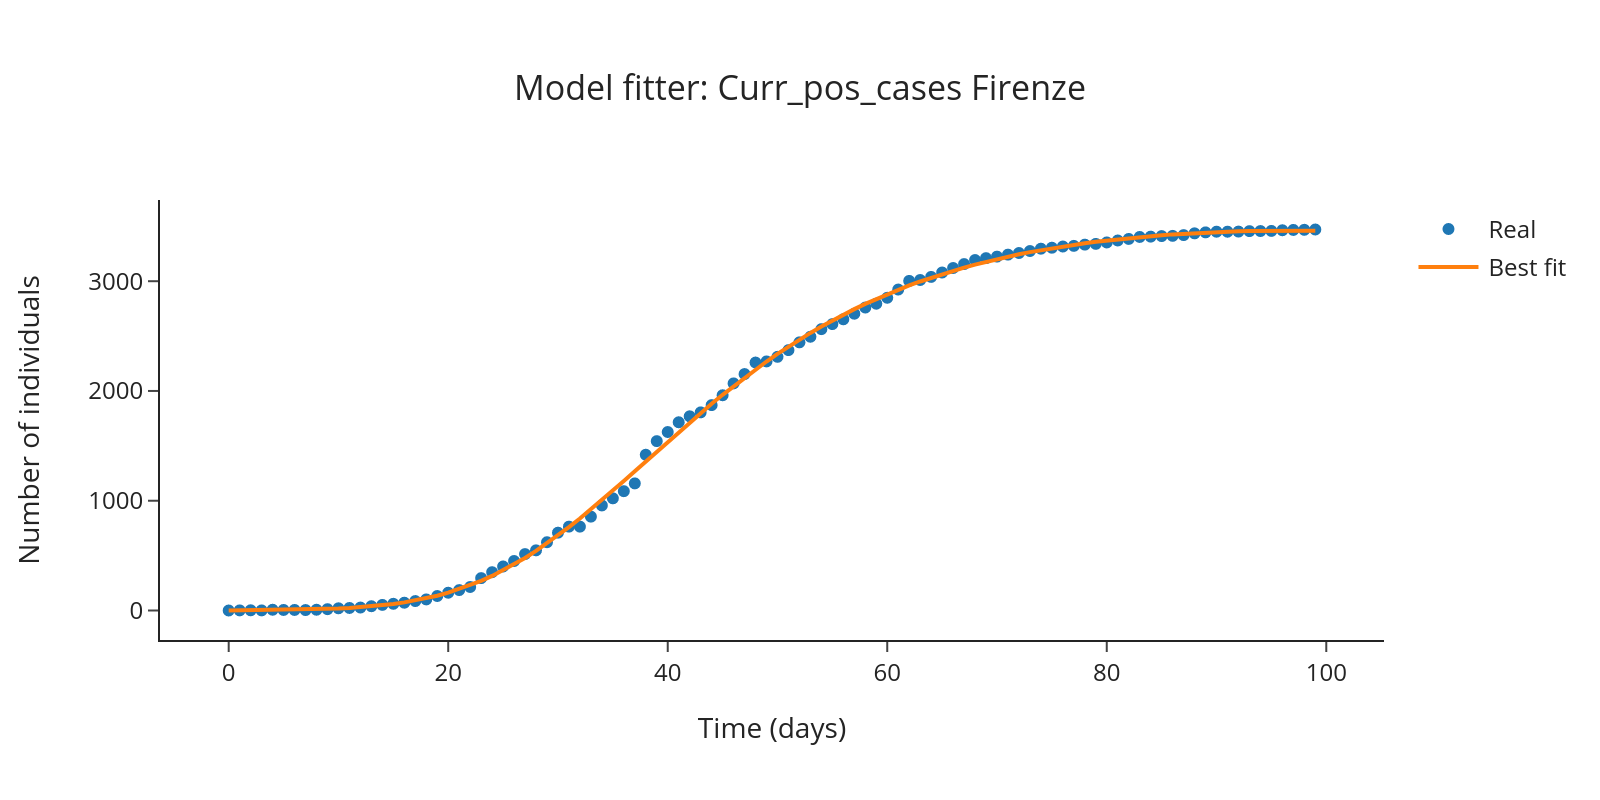

In [23]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [24]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(21.052558582188144, 1048.8566477536028)

In [25]:
result.best_values

{'R_0_start': 4.000600973282221,
 'k': 0.08401433194087307,
 'x0': 18.41220330012675,
 'R_0_end': 1.3212587303965662,
 'alpha': 0.045202765880996774,
 'gamma': 0.140155310496441}

In [26]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

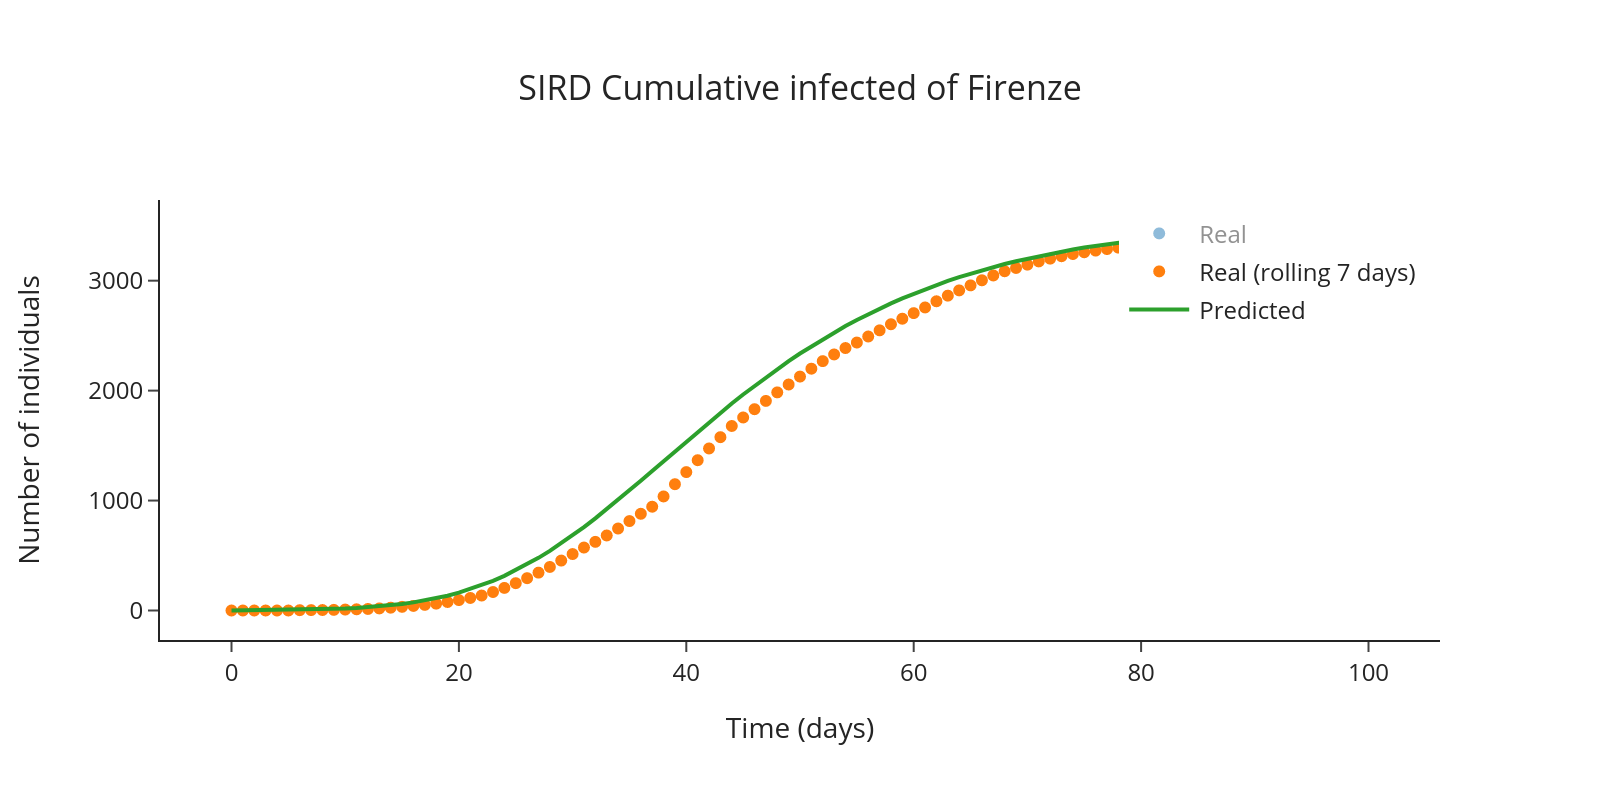

In [27]:
names, title, data, _ = data_for_plot('Cumulative infected', covidpro_df, 'Curr_pos_cases', I, province)
times = list(range(sirsol.shape[1]))

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [28]:
# Error here is shown on the rolling 7 days!
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(103.01746070219464, 19309.73755678003)

### Daily infected - Firenze
No outbreak shift

In [29]:
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

In [30]:
time = datetime.datetime.now()

result = mod.fit(y_data, params, method="leastsq", x=x_data)

print('Fitting completed in {}'.format(datetime.datetime.now() - time))

Fitting completed in 0:00:01.070037


In [31]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 467
    # data points      = 100
    # variables        = 6
    chi-square         = 5137.54834
    reduced chi-square = 54.6547696
    Akaike info crit   = 405.916108
    Bayesian info crit = 421.547129
[[Variables]]
    R_0_start:  3.05288038 +/- 413.392448 (13541.06%) (init = 3.5)
    k:          0.14421469 +/- 0.05549546 (38.48%) (init = 0.3)
    x0:         35.1144714 +/- 2.75302411 (7.84%) (init = 20)
    R_0_end:    1.75653544 +/- 62.2097625 (3541.62%) (init = 0.9)
    alpha:      0.21732658 +/- 47.6931081 (21945.36%) (init = 0.1)
    gamma:      0.16314855 +/- 46.7198532 (28636.39%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, gamma)   = -0.993
    C(alpha, gamma)       =  0.980
    C(R_0_start, alpha)   = -0.949
    C(x0, alpha)          = -0.934
    C(x0, gamma)          = -0.928
    C(k, alpha)           =  0.910
    C(R_0_start, x0)      =  0.906
    C(

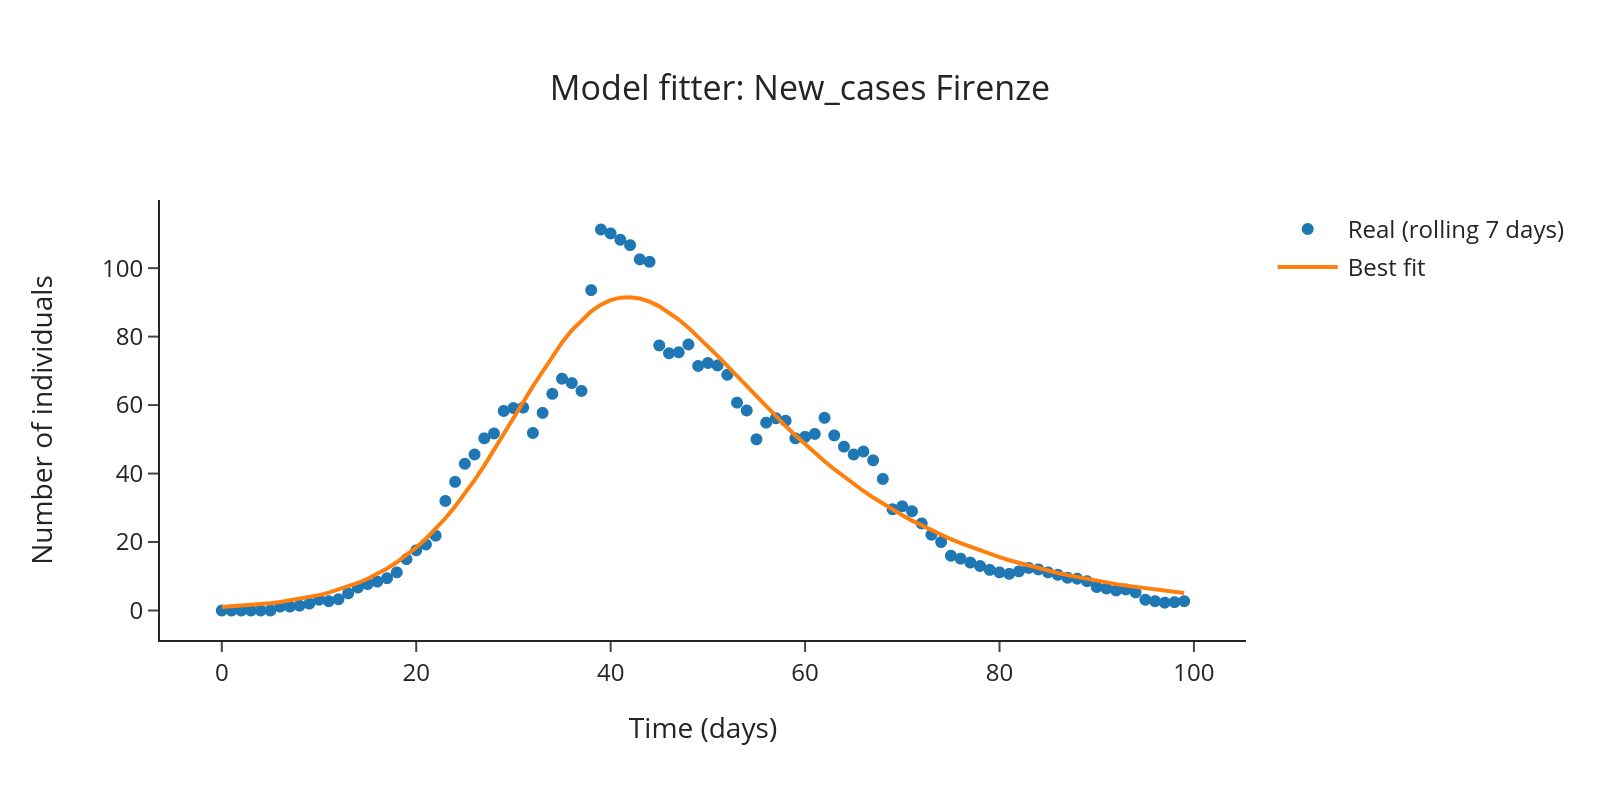

In [32]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real (rolling 7 days)', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [33]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(5.202194053266722, 51.37548343795631)

In [34]:
result.best_values

{'R_0_start': 3.052880378004642,
 'k': 0.1442146900847878,
 'x0': 35.11447143059068,
 'R_0_end': 1.7565354397122144,
 'alpha': 0.2173265751223985,
 'gamma': 0.16314855326415773}

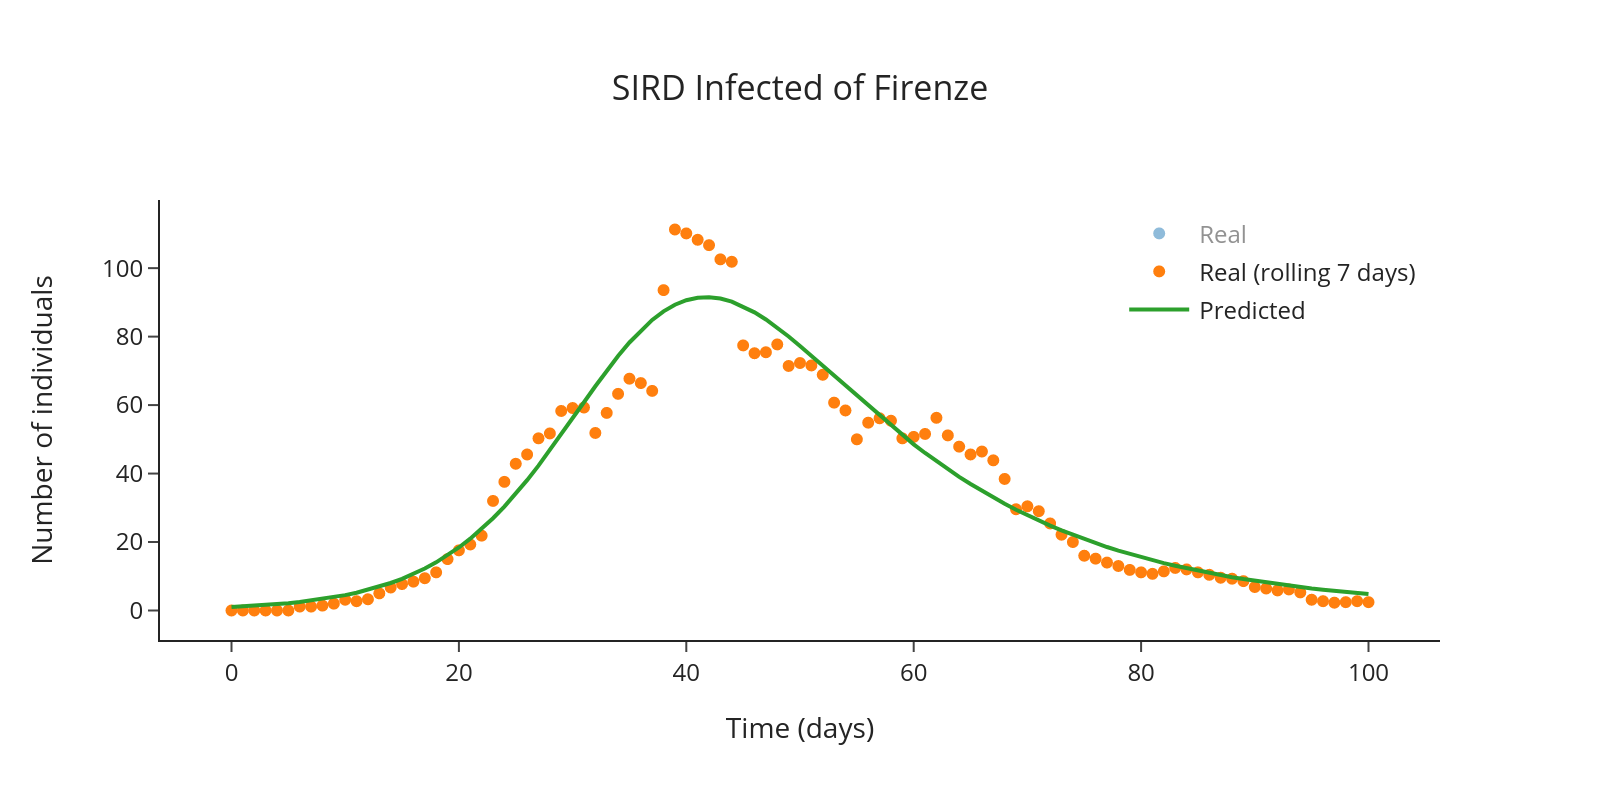

In [35]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, 'New_cases', I, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [36]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(5.174296292663379, 50.92311168845561)

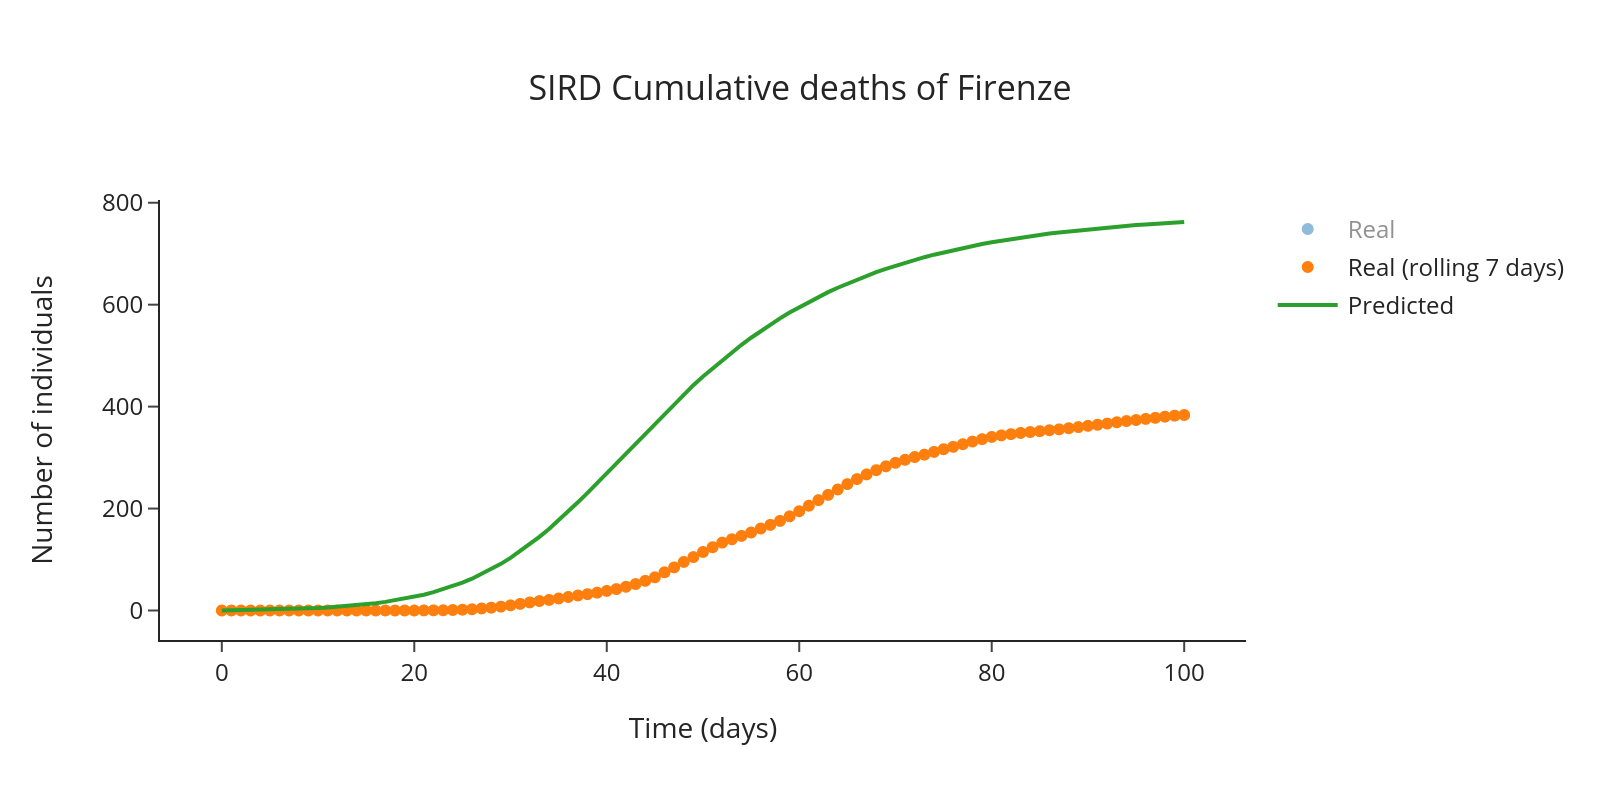

In [37]:
names, title, data, _ = data_for_plot('Cumulative deaths', covidpro_df, 'Tot_deaths', D, province)
times = list(range(sirsol.shape[1]))

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=False,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [38]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(244.3075423180887, 85893.60453131823)

### Daily infected - Firenze
Outbreak shift = 10

In [38]:
province = 'Firenze'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=10)

result = mod.fit(y_data, params, method="leastsq", x=x_data)

lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1262
    # data points      = 110
    # variables        = 6
    chi-square         = 5002.23991
    reduced chi-square = 48.0984607
    Akaike info crit   = 431.887678
    Bayesian info crit = 448.090560
[[Variables]]
    R_0_start:  4.05215671 +/- 1.31330311 (32.41%) (init = 3.5)
    k:          2.93264960 +/- 17.4557225 (595.22%) (init = 0.3)
    x0:         49.9246389 +/- 2.58447307 (5.18%) (init = 20)
    R_0_end:    3.50000000 +/- 1.26515891 (36.15%) (init = 0.9)
    alpha:      0.90631996 +/- 2.23885190 (247.03%) (init = 0.1)
    gamma:      0.25301505 +/- 0.45485163 (179.77%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, gamma)       =  0.984
    C(k, x0)              = -0.929
    C(x0, alpha)          =  0.889
    C(k, alpha)           = -0.884
    C(x0, R_0_end)        =  0.828
    C(k, gamma)           = -0.812
    C(x0, gamma)          =  0.797
    C(k, R_0_

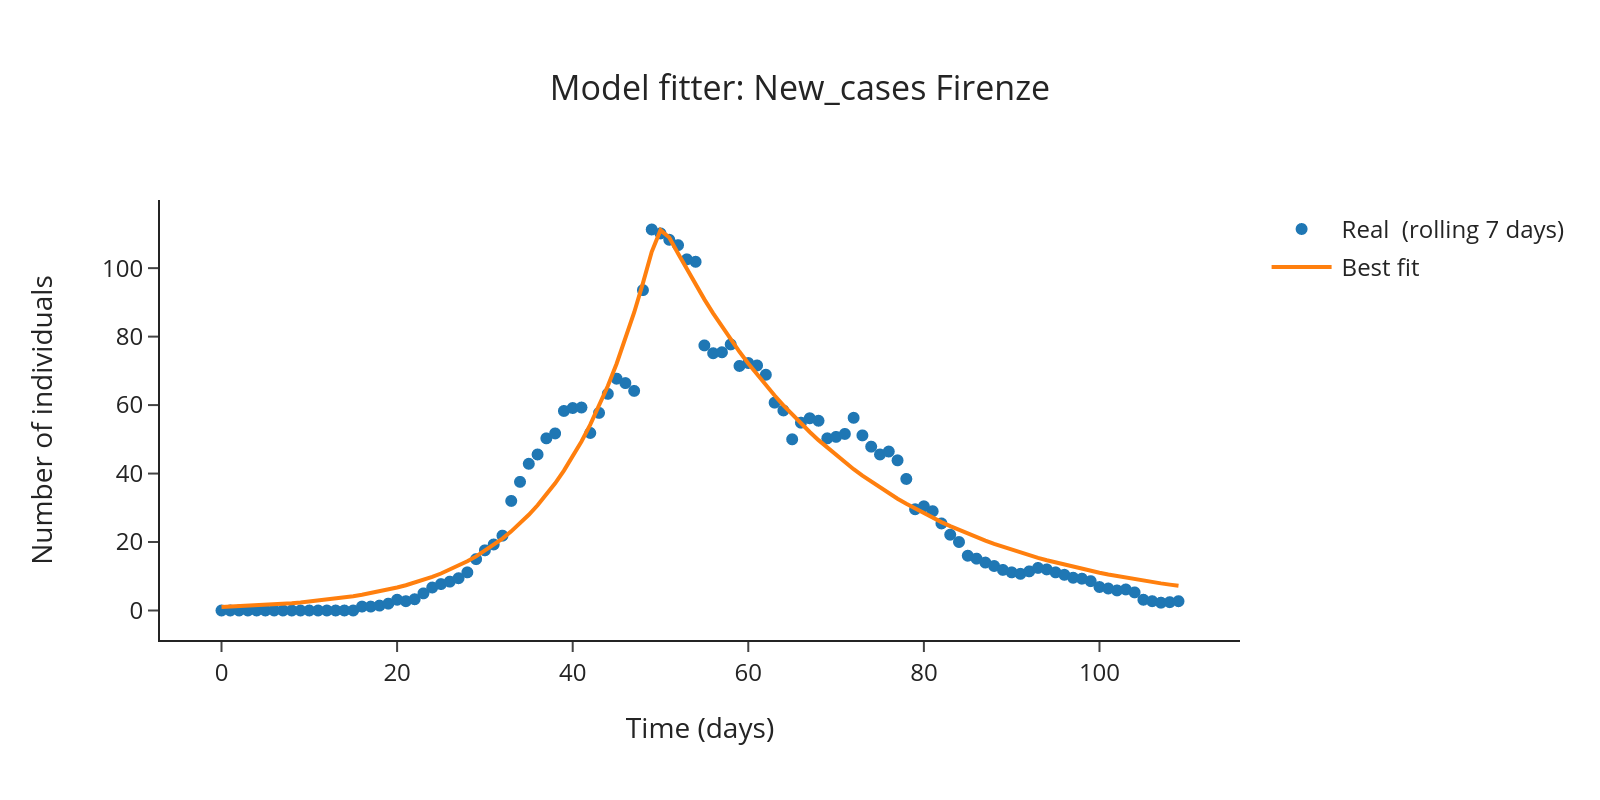

In [39]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real  (rolling 7 days)', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [40]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(5.1353624823786514, 45.474908307785185)

In [41]:
result.best_values

{'R_0_start': 4.052156711003933,
 'k': 2.9326495956369127,
 'x0': 49.92463894319742,
 'R_0_end': 3.4999999963869994,
 'alpha': 0.9063199642227926,
 'gamma': 0.2530150538119541}

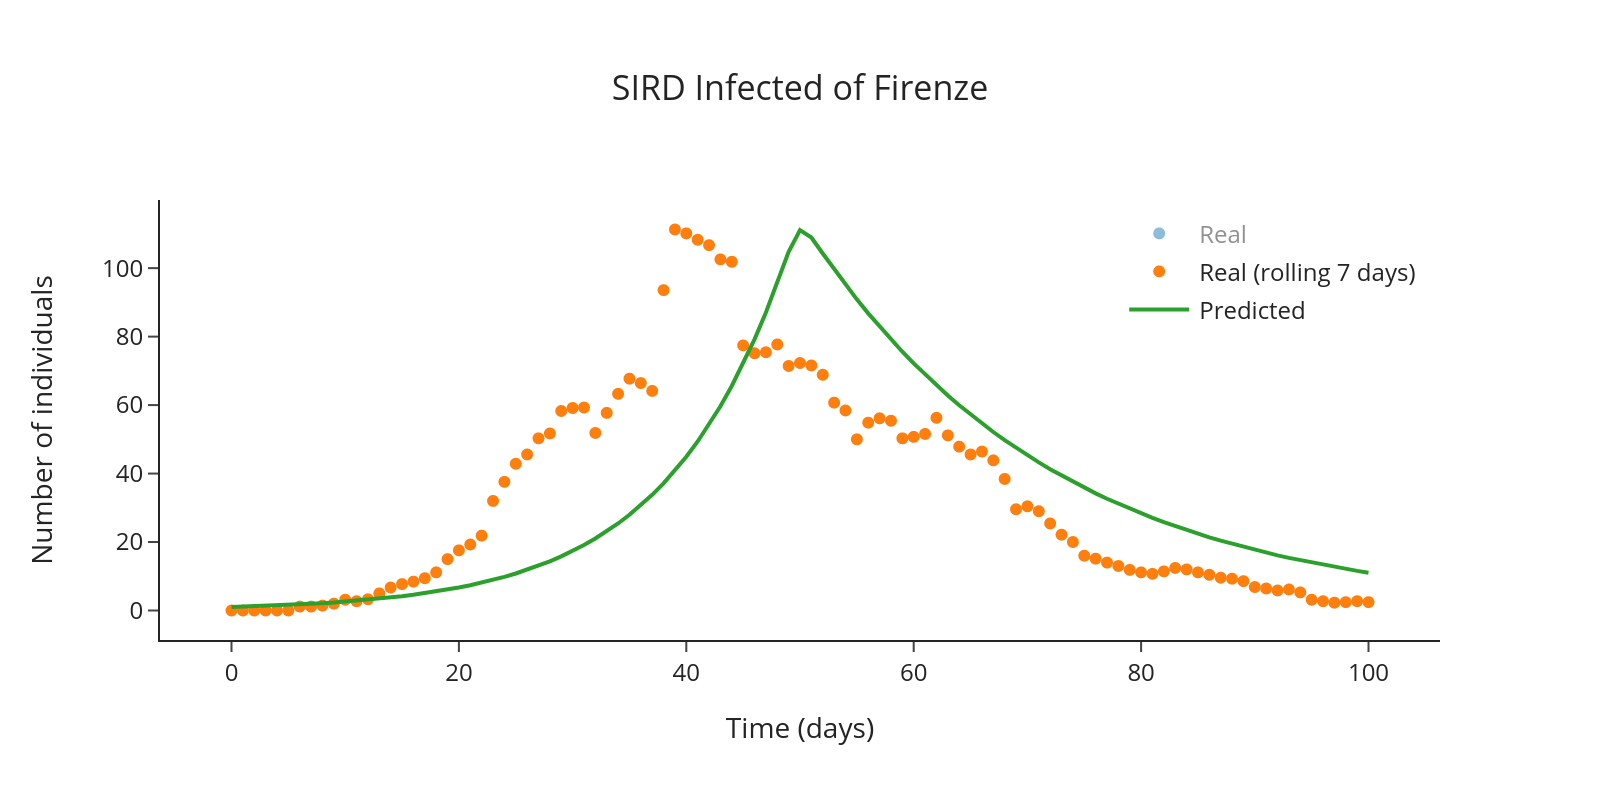

In [42]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, 'New_cases', I, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [43]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(19.113807034585523, 613.9534468451312)

### Daily infected - Bologna
No outbreak shift

In [10]:
province = 'Bologna'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

result = mod.fit(y_data, params, method="leastsq", x=x_data)

lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 728
    # data points      = 100
    # variables        = 6
    chi-square         = 5177.09762
    reduced chi-square = 55.0755066
    Akaike info crit   = 406.682969
    Bayesian info crit = 422.313990
[[Variables]]
    R_0_start:  3.85781475 +/- 0.77411065 (20.07%) (init = 3.5)
    k:          0.75424466 +/- 0.26522806 (35.16%) (init = 0.3)
    x0:         32.6953830 +/- 0.32227397 (0.99%) (init = 20)
    R_0_end:    3.15554101 +/- 0.46050078 (14.59%) (init = 0.9)
    alpha:      0.84599519 +/- 2.05883003 (243.36%) (init = 0.1)
    gamma:      0.27053191 +/- 0.46207082 (170.80%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, gamma)       =  1.000
    C(R_0_start, gamma)   = -1.000
    C(R_0_start, alpha)   = -1.000
    C(R_0_end, alpha)     =  1.000
    C(R_0_end, gamma)     =  1.000
    C(R_0_start, R_0_end) = -1.000
    C(k, R_0_end)         =  0.261
    C(R_0_start

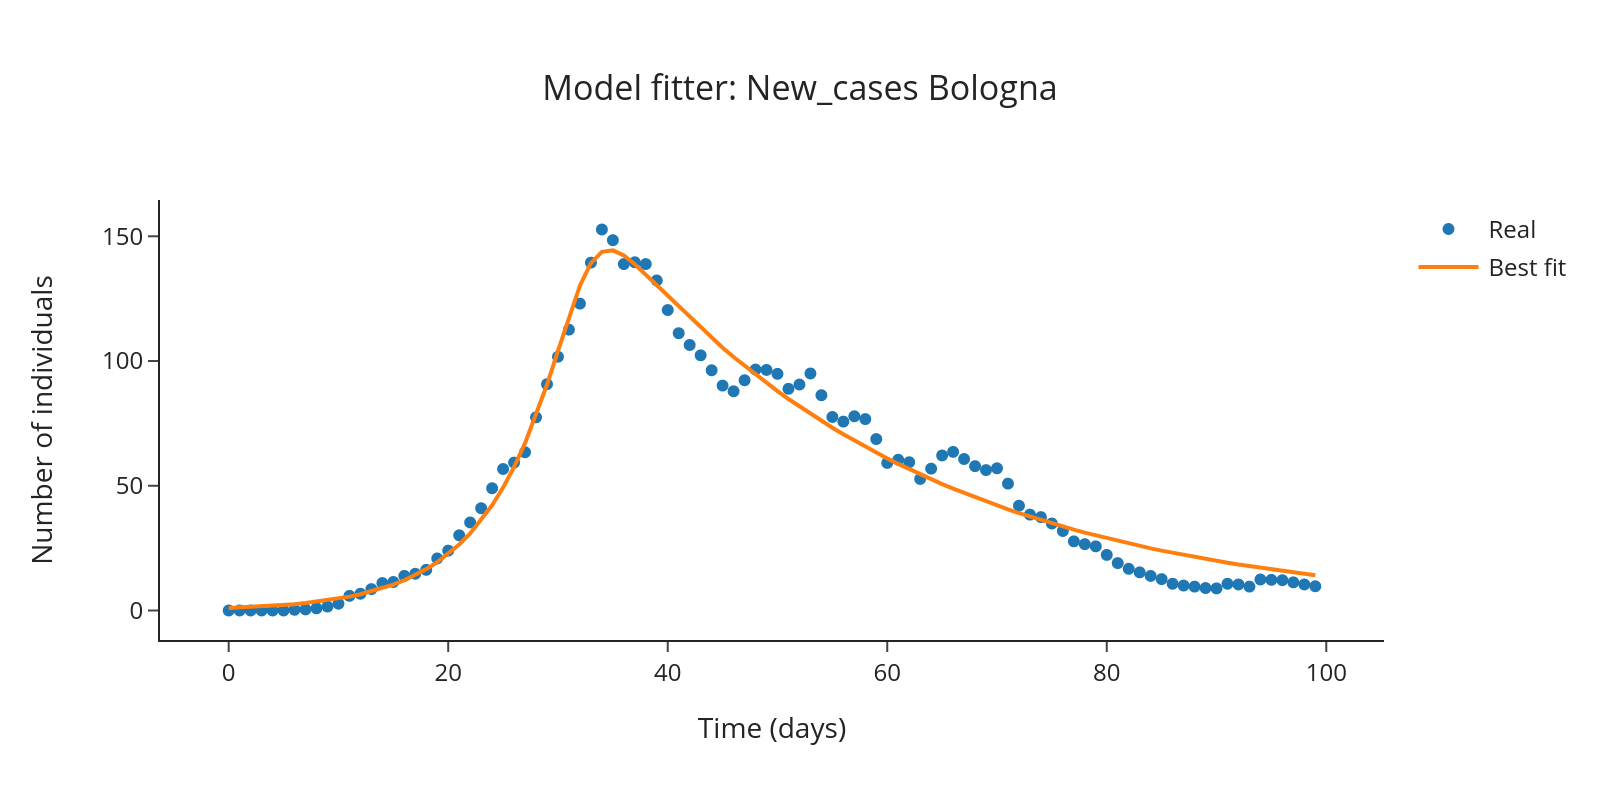

In [11]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [12]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(5.688712301757504, 51.77097619740428)

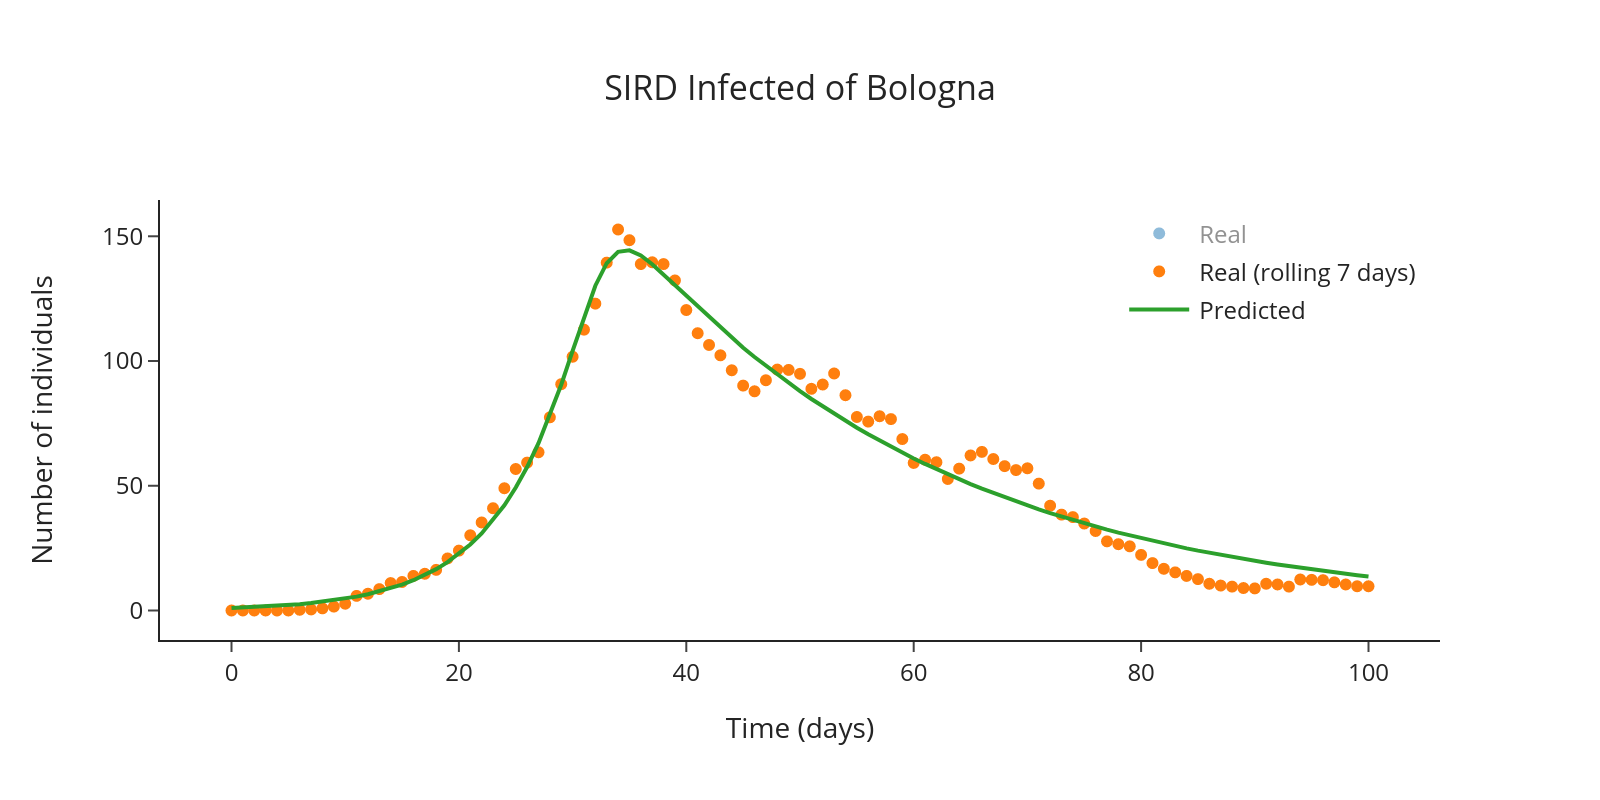

In [14]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, 'New_cases', I, province)
times = list(range(sirsol.shape[1]))

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [15]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(5.671218728735603, 51.410679374153005)

### Deaths of Firenze

In [43]:
province = 'Firenze'
compart = 'Tot_deaths'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

result = mod.fit(y_data, params, method="leastsq", x=x_data)

lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 716
    # data points      = 100
    # variables        = 6
    chi-square         = 1835.09090
    reduced chi-square = 19.5222436
    Akaike info crit   = 302.967911
    Bayesian info crit = 318.598932
[[Variables]]
    R_0_start:  2.97333634 +/- 3707.81606 (124702.21%) (init = 3.5)
    k:          0.07053673 +/- 0.39938950 (566.21%) (init = 0.3)
    x0:         40.9606482 +/- 58.0157590 (141.64%) (init = 20)
    R_0_end:    0.32330740 +/- 1252.06758 (387268.46%) (init = 0.9)
    alpha:      0.01152189 +/- 0.02590452 (224.83%) (init = 0.1)
    gamma:      0.11878142 +/- 222.433658 (187263.00%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, R_0_end) = -1.000
    C(R_0_start, gamma)   = -1.000
    C(R_0_end, gamma)     =  1.000
    C(k, gamma)           = -0.998
    C(R_0_start, k)       =  0.998
    C(k, R_0_end)         = -0.998
    C(k, x0)              =  0.998
 

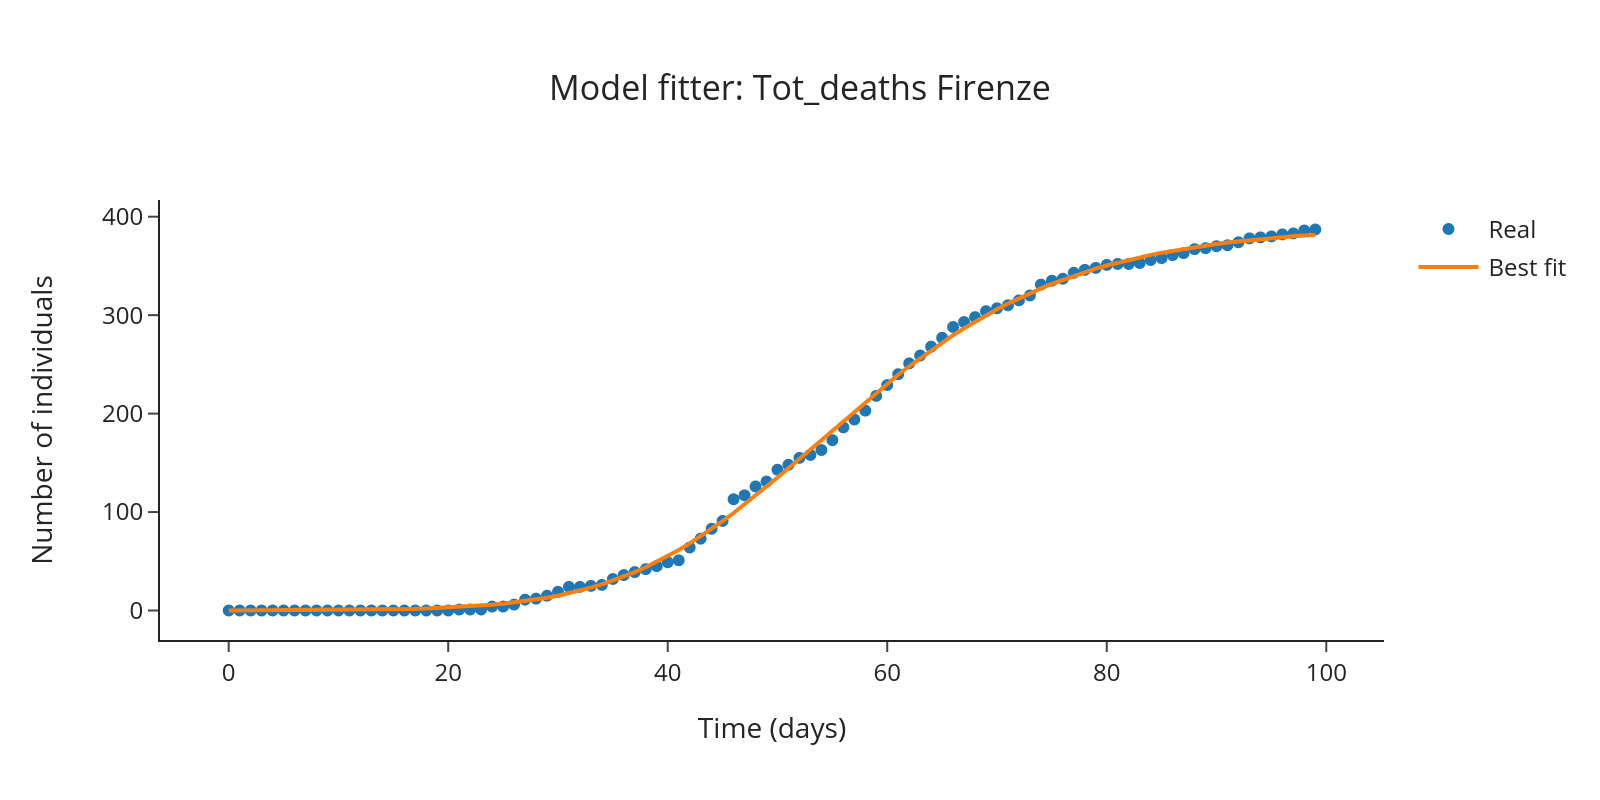

In [44]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [45]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(3.173061596258741, 18.350908956097907)

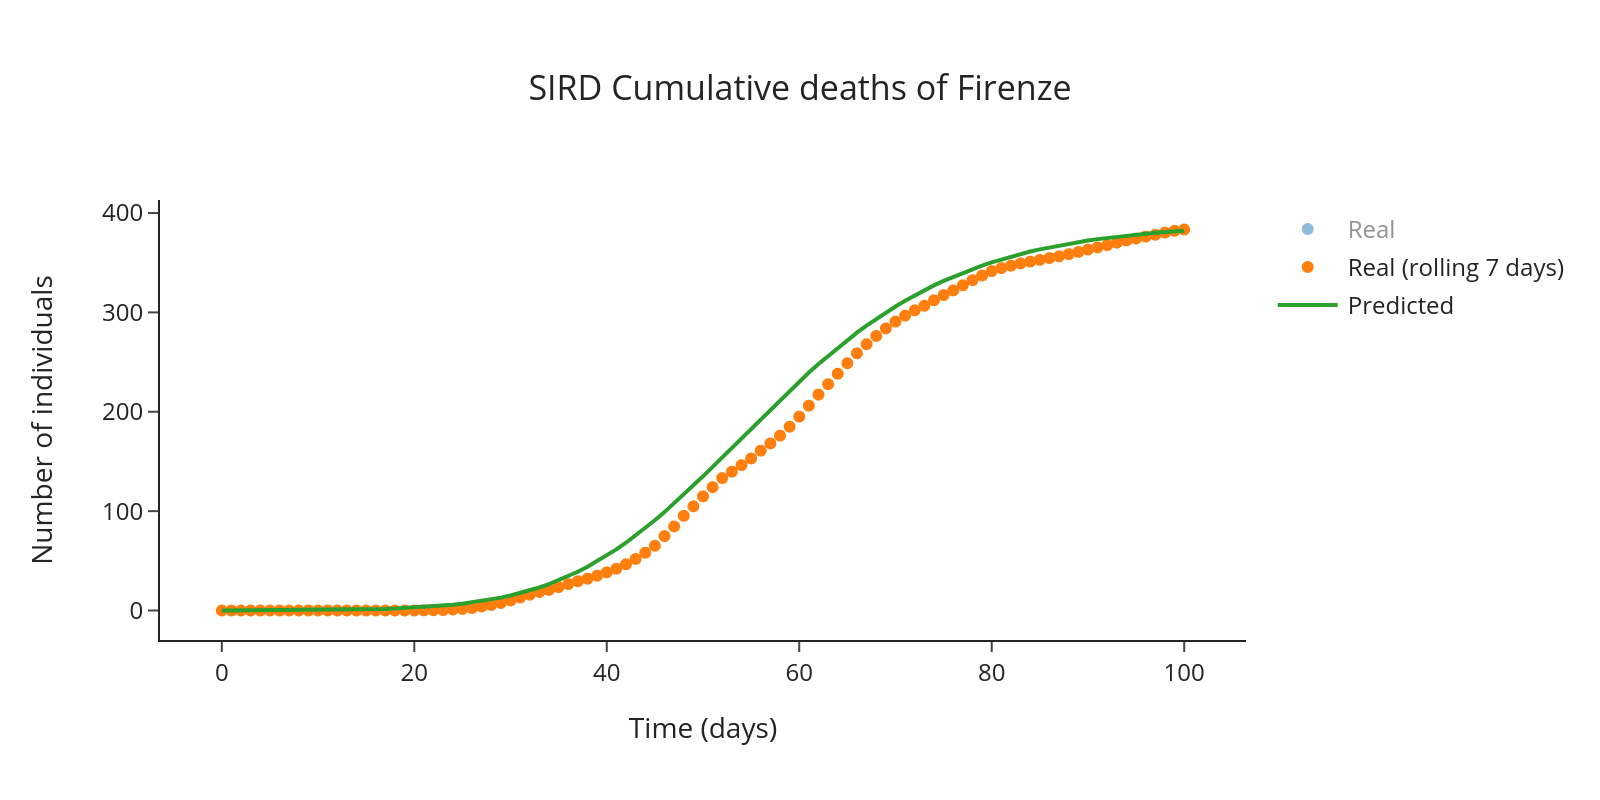

In [48]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Cumulative deaths', covidpro_df, 'Tot_deaths', D, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=False,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [37]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(11.608808780074535, 239.59051866004114)

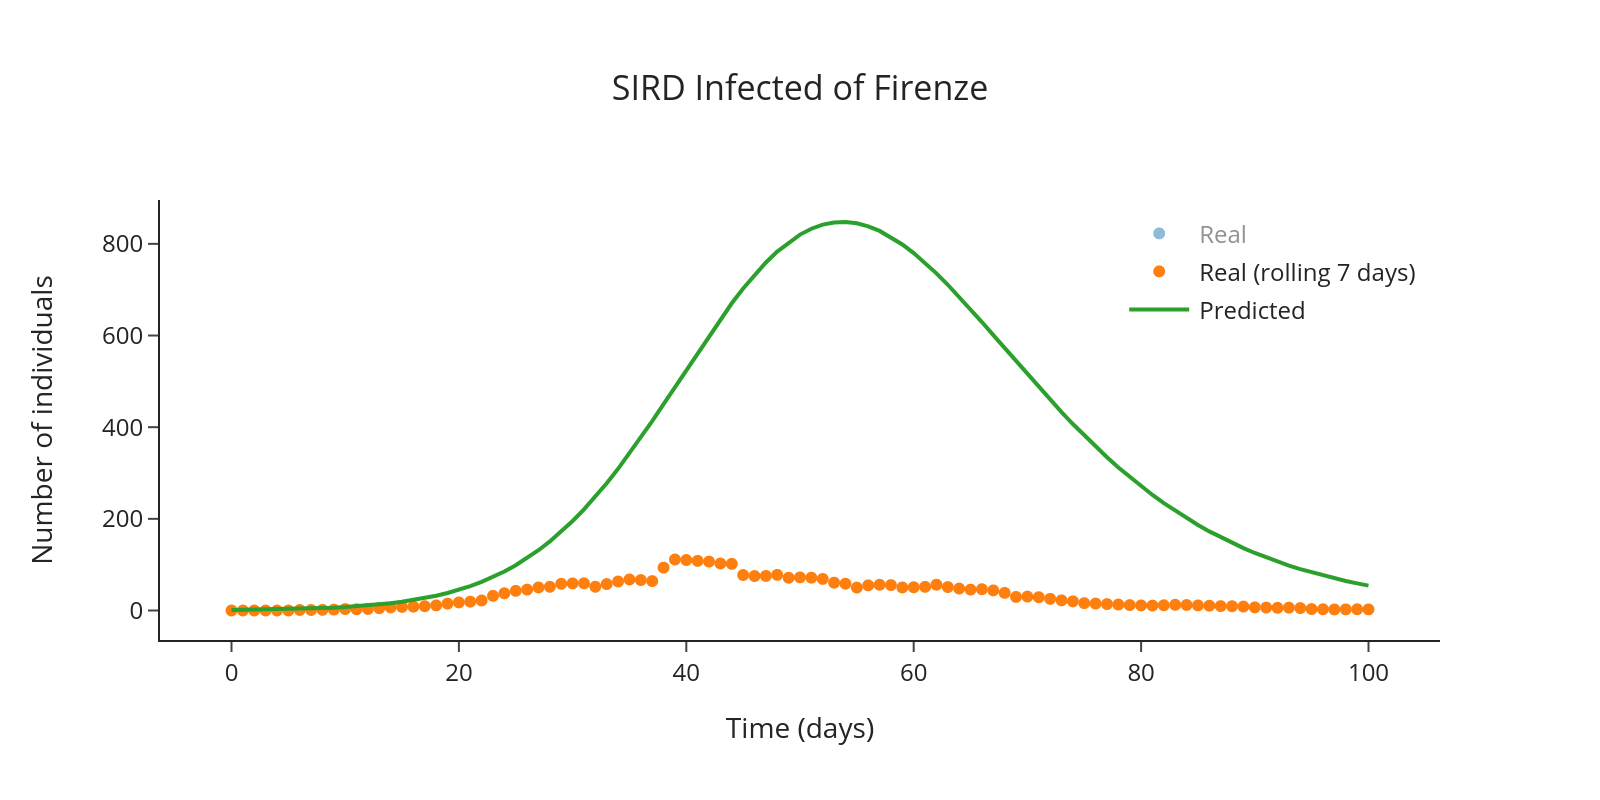

In [41]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, 'New_cases', I, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [42]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(294.3665101336331, 159799.66154737442)

### Skewed gaussian param estimation - Bologna
No outbreak shift

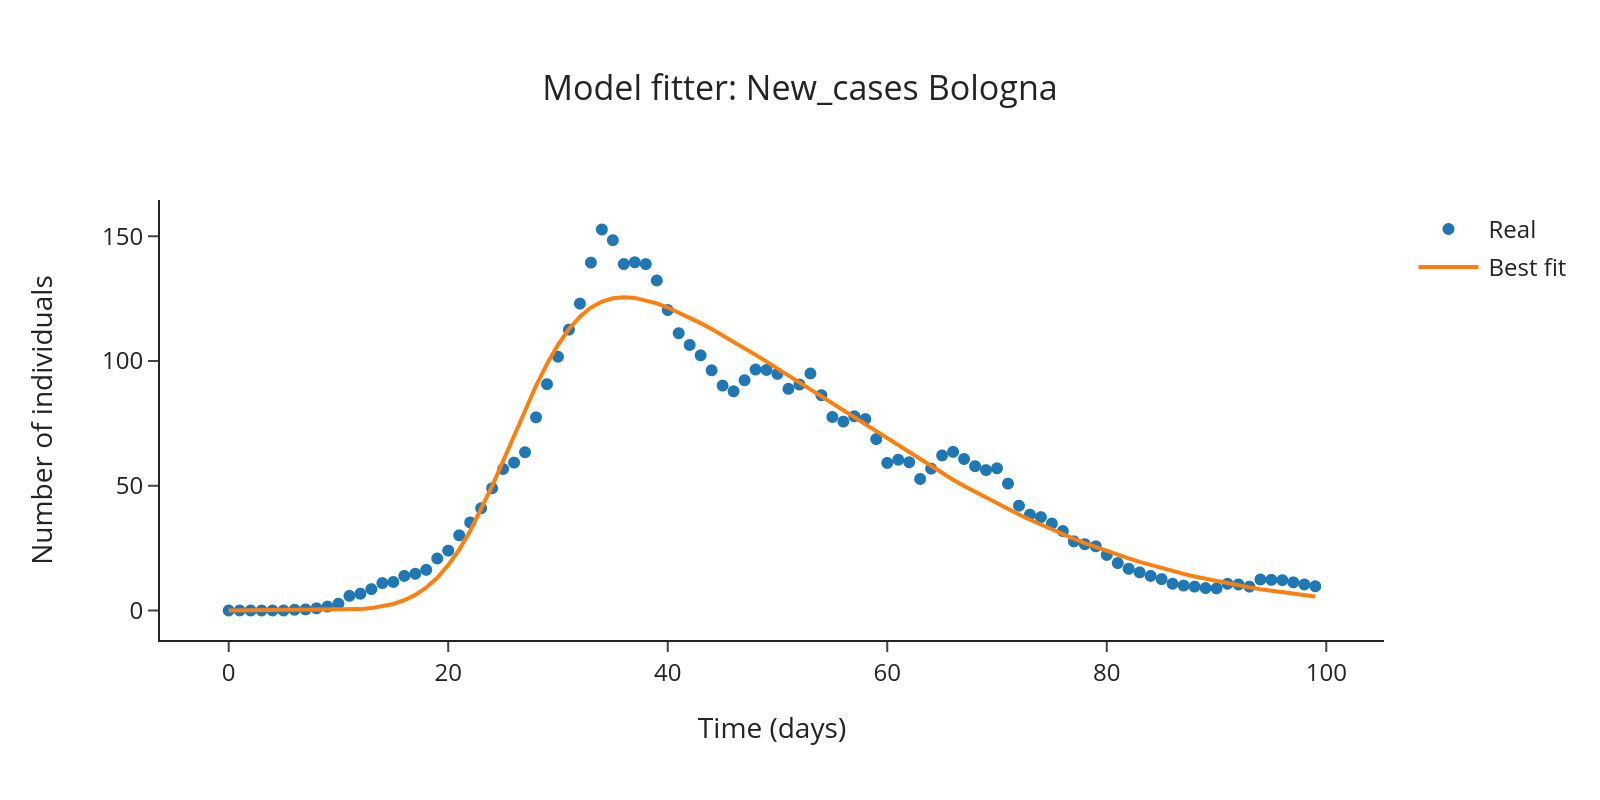

In [49]:
from lmfit.models import SkewedGaussianModel

province = 'Bologna'
compart = 'New_cases'

_, _, y_data, x_data, _, _ = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

model = SkewedGaussianModel()
params = model.guess(y_data, x=x_data)

result = model.fit(y_data, params, x=x_data)

general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [50]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(6.034830571902737, 68.41045143333051)

In [51]:
print(lmfit.fit_report(result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 100
    # variables        = 4
    chi-square         = 6841.04514
    reduced chi-square = 71.2608869
    Akaike info crit   = 430.552561
    Bayesian info crit = 440.973242
[[Variables]]
    amplitude:  4980.53084 +/- 80.1918752 (1.61%) (init = 6872.143)
    center:     25.8493059 +/- 0.30152642 (1.17%) (init = 42.56667)
    sigma:      28.9202731 +/- 0.66437112 (2.30%) (init = 15)
    gamma:      5.45079057 +/- 0.50824227 (9.32%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.591
    C(sigma, gamma)      =  0.552
    C(amplitude, sigma)  =  0.522
    C(center, gamma)     = -0.377
    C(amplitude, center) = -0.290


### Region Piemonte

In [41]:
mapping_regional = {
    'nuovi_positivi': 2,
    'totale_positivi': 2,
    'deceduti_giorni0': 4,
    'deceduti': 4,
}

def fitter_regional(x, R_0_start, k, x0, R_0_end, alpha, gamma):
    ret = Model(days, N, R_0_start, k, x0, R_0_end, alpha, gamma)
    return ret[mapping_regional[compart]][x]

In [42]:
def get_model_regional(region, compart, data_df, pop_df, params_init_min_max=None, query='20200603 > data', outbreak_shift=20, window=7):
    data = data_df[data_df.denominazione_regione == region].query(query)[compart]
    if compart in ['nuovi_positivi', 'deceduti_giorno']:
        data = data.rolling(window).mean().fillna(0)
    
    N = get_region_pop(region, pop_df, prov_list_df)

    # {parameter: (initial guess, min value, max value)}
    if params_init_min_max == None:
        params_init_min_max = {
            "R_0_start": (3.5, 1.0, 6),
            "k": (0.3, 0.01, 5.0),
            "x0": (20, 0, 100),
            "R_0_end": (0.9, 0.01, 3.5),
            "alpha": (0.1, 0.00000001, 1),
            "gamma": (1/7, 0.00000001, 1)
        }

    days = outbreak_shift + len(data)

    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    # [0, 1, ..., days]
    x_data = np.linspace(0, days-1, days, dtype=int)

    mod = lmfit.Model(fitter_regional)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()

    return mod, params, y_data, x_data, days, N

In [59]:
province = 'Piemonte'
compart = 'totale_positivi'

mod, params, y_data, x_data, days, N = get_model_regional(province, compart, dpc_regioni_df, pop_prov_df, outbreak_shift=0)

In [60]:
time = datetime.datetime.now()

result = mod.fit(y_data, params, method="leastsq", x=x_data)

print('Fitting done in {}'.format(datetime.datetime.now() - time))

Fitting done in 0:00:02.065748


In [61]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 796
    # data points      = 100
    # variables        = 6
    chi-square         = 7653709.68
    reduced chi-square = 81422.4434
    Akaike info crit   = 1136.55308
    Bayesian info crit = 1152.18410
[[Variables]]
    R_0_start:  2.81509466 +/- 4425.94420 (157221.86%) (init = 3.5)
    k:          0.40670848 +/- 0.07517720 (18.48%) (init = 0.3)
    x0:         23.2394664 +/- 0.84675312 (3.64%) (init = 20)
    R_0_end:    2.05528883 +/- 3231.82136 (157244.15%) (init = 0.9)
    alpha:      0.57836314 +/- 424.531616 (73402.26%) (init = 0.1)
    gamma:      0.39056083 +/- 613.822884 (157164.48%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_end, gamma)     = -1.000
    C(R_0_start, gamma)   = -1.000
    C(R_0_start, R_0_end) =  1.000
    C(R_0_end, alpha)     =  1.000
    C(alpha, gamma)       = -1.000
    C(R_0_start, alpha)   =  1.000
    C(k, x0)              =  0.882


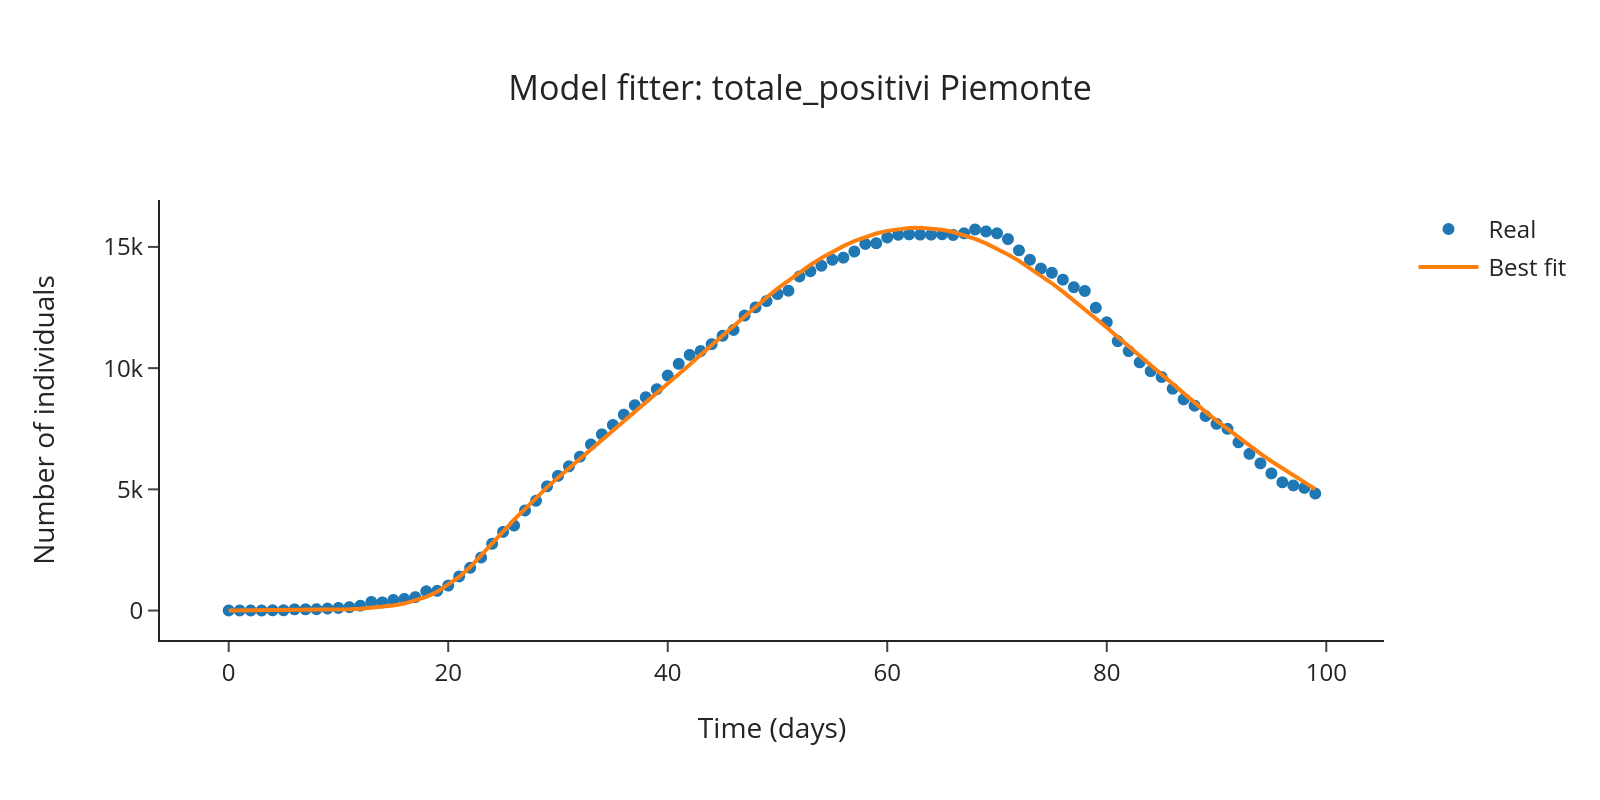

In [62]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [63]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(220.20614105784284, 76537.0967817327)

In [64]:
result.best_values

{'R_0_start': 2.8150946636121557,
 'k': 0.40670848072457977,
 'x0': 23.23946640539682,
 'R_0_end': 2.055288830367861,
 'alpha': 0.5783631359463409,
 'gamma': 0.39056082816987375}

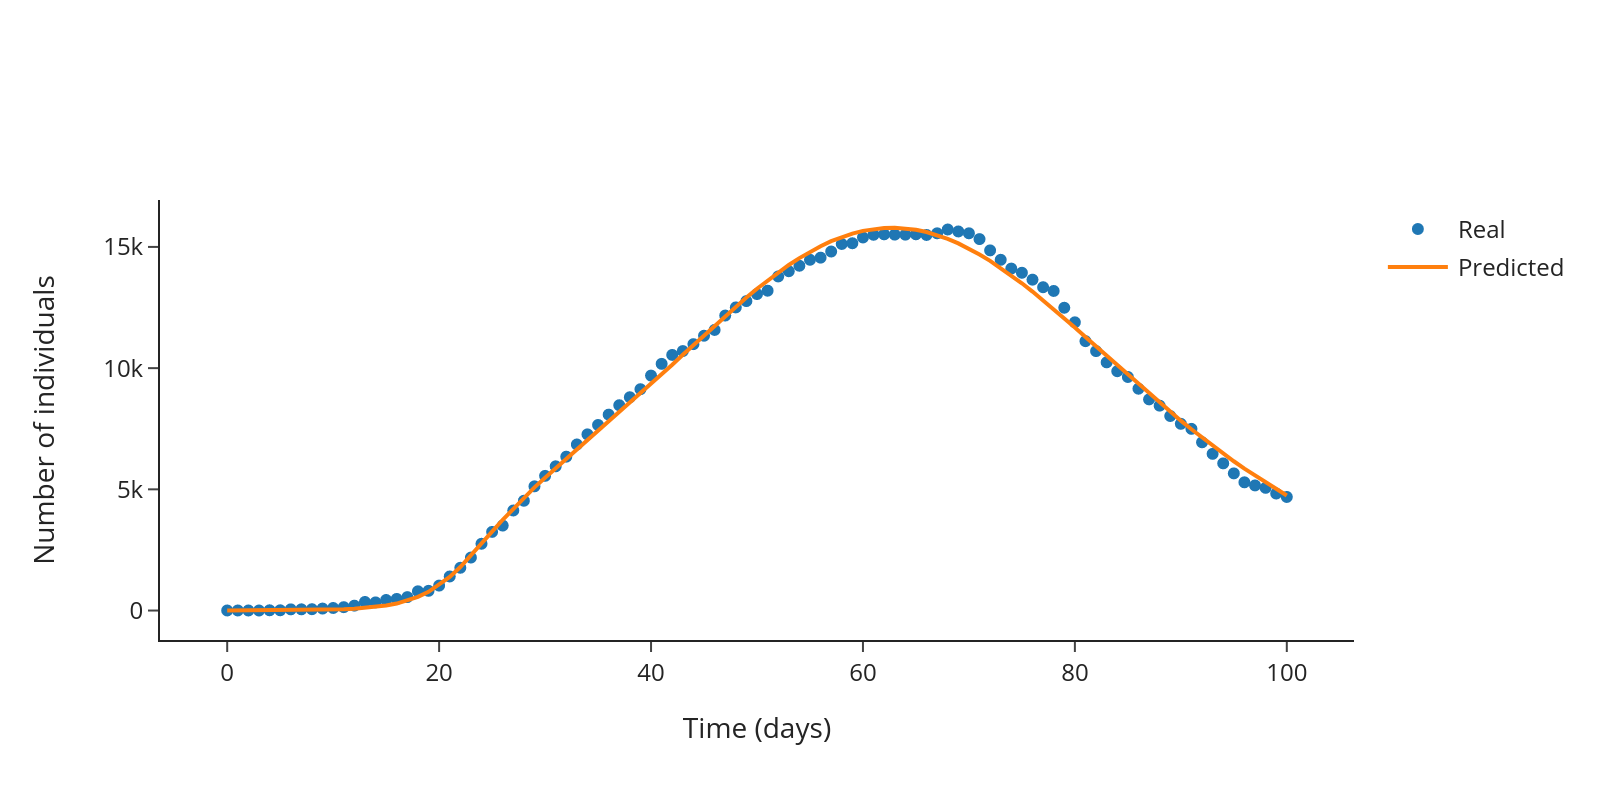

In [72]:
sirsol = sird(
        province=province,
        pop_prov_df=pop_prov_df,
        prov_list_df=prov_list_df,
        **result.best_values
    )
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', dpc_regioni_df, 'totale_positivi', I, province, is_regional=True)

general_plot(t=times,
             title='',
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=False,
             output_image=True,
             traces_visibility=[True,False,True])

In [75]:
mean_absolute_error(data[0], data[2]), mean_squared_error(data[0], data[2])

(218.6231480154896, 75815.33311189787)

## Discrete SIRD
Discrete parameter estimation using LinearRegression.

Compute parameters for each day and then predict new days

In [52]:
regione = 'Piemonte'
pop = get_region_pop(regione, pop_prov_df, prov_list_df)

filtered_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == regione][['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi', 'nuovi_positivi']]

filtered_df = filtered_df.query('20200630 > data')

filtered_df['suscettibili'] = pop - filtered_df['totale_casi']

filtered_df = filtered_df[['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'suscettibili', 'nuovi_positivi']]

In [53]:
n = filtered_df.shape[0]

gamma = np.diff(filtered_df['dimessi_guariti'].values)/filtered_df.iloc[:n-1]['totale_positivi'].values
alpha = np.diff(filtered_df['deceduti'].values)/filtered_df.iloc[:n-1]['totale_positivi'].values
beta = (pop/filtered_df.iloc[:n-1]['suscettibili'].values)*(np.diff(filtered_df['totale_positivi'].values)+np.diff(filtered_df['dimessi_guariti'].values)+np.diff(filtered_df['deceduti'].values))/filtered_df.iloc[:n-1]['totale_positivi'].values
R0 = beta/(gamma+alpha)

In [54]:
def fix_arr(arr):
    arr[arr < 0] = 0
    arr[np.isinf(arr)] = 0
    return np.nan_to_num(arr)

gamma = fix_arr(gamma)
alpha = fix_arr(alpha)
beta = fix_arr(beta)
R0 = fix_arr(R0)

In [55]:
def lag_data(data, lag=5, return_all=False):
    N = len(data)
    X = np.empty(shape=(N-lag, lag+1))

    for i in range(lag, N):
        X[i-lag,] = [data[i-j] for j in range(lag+1)]
    
    if not return_all:
        return X[-1,1:]
    else:
        return X[:,1:], X[:,0]

In [56]:
from sklearn.linear_model import LinearRegression

lag = 7
reg_beta = LinearRegression().fit(*lag_data(beta, lag, True))
reg_gamma = LinearRegression().fit(*lag_data(gamma, lag, True))
reg_alpha = LinearRegression().fit(*lag_data(alpha, lag, True))

In [57]:
days_to_predict = 14

S = np.zeros(days_to_predict + 2)
I = np.zeros(days_to_predict + 2)
R = np.zeros(days_to_predict + 2)
D = np.zeros(days_to_predict + 2)
S[0] = filtered_df.iloc[-1]['suscettibili']
I[0] = filtered_df.iloc[-1]['totale_positivi']
R[0] = filtered_df.iloc[-1]['dimessi_guariti']
D[0] = filtered_df.iloc[-1]['deceduti']

for i in range(days_to_predict + 1):
    _beta = fix_arr(reg_beta.predict(lag_data(beta, lag).reshape(1, -1)))
    _gamma = fix_arr(reg_gamma.predict(lag_data(gamma, lag).reshape(1, -1)))
    _alpha = fix_arr(reg_alpha.predict(lag_data(alpha, lag).reshape(1, -1)))

    beta = np.append(beta, _beta, axis = 0)
    gamma = np.append(gamma, _gamma, axis = 0)
    alpha = np.append(alpha, _alpha, axis = 0)

    dIdt = np.round((1 + _beta * (S[i]/pop) - _gamma - _alpha)*I[i])
    dRdt = np.round(R[i] + _gamma * I[i])
    dDdt = np.round(D[i] + _alpha * I[i])
    dSdt = pop-dIdt[0]-dRdt[0]-dDdt[0]

    S[i+1] = dSdt
    I[i+1] = dIdt
    R[i+1] = dRdt
    D[i+1] = dDdt

S = S[1:]
I = I[1:]
R = R[1:]
D = D[1:]

In [58]:
dates = pd.date_range(start=(filtered_df.iloc[-1]['data'] + pd.DateOffset(1)).strftime('%Y-%m-%d'), periods=days_to_predict + 1)

tmp_df = pd.DataFrame(np.column_stack([np.zeros(days_to_predict + 1), I, R, D, S]),
    columns = [
        'data',
        'totale_positivi', 
        'dimessi_guariti',
        'deceduti', 
        'suscettibili'])

tmp_df['data'] = dates

In [59]:
filtered_df = pd.concat([filtered_df, tmp_df], ignore_index=True)

In [60]:
filtered_df['nuovi_positivi'] = [0]+list(np.diff(filtered_df['totale_positivi'].values)+np.diff(filtered_df['dimessi_guariti'].values)+np.diff(filtered_df['deceduti'].values))

filtered_df['nuovi_positivi'] = filtered_df['nuovi_positivi'].apply(lambda x: 0 if x < 0 else x)

beta = np.append(beta, np.zeros((1,)), axis = 0)
gamma = np.append(gamma, np.zeros((1,)), axis = 0)
alpha = np.append(alpha, np.zeros((1,)), axis = 0)

filtered_df['beta'] = beta
filtered_df['gamma'] = gamma
filtered_df['alpha'] = alpha
filtered_df['R0'] = fix_arr(beta/(gamma+alpha))
filtered_df = filtered_df[:-1]

In [61]:
filtered_df = filtered_df.astype({'totale_positivi': 'int32',
'dimessi_guariti': 'int32', 'deceduti': 'int32', 'suscettibili': 'int32', 'nuovi_positivi': 'int32'})

In [62]:
filtered_df

,data,totale_positivi,dimessi_guariti,deceduti,suscettibili,nuovi_positivi,beta,gamma,alpha,R0
0,2020-02-24,3,0,0,4341372,0,0.000000,0.000000,0.000000,0.000000
1,2020-02-25,3,0,0,4341372,0,0.000000,0.000000,0.000000,0.000000
2,2020-02-26,3,0,0,4341372,0,0.000000,0.000000,0.000000,0.000000
3,2020-02-27,2,0,0,4341373,0,4.500002,0.000000,0.000000,0.000000
4,2020-02-28,11,0,0,4341364,9,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
136,2020-07-09,1262,26251,4135,4309727,35,0.027141,0.030085,0.004501,0.784739
137,2020-07-10,1252,26289,4141,4309693,34,0.028250,0.034143,0.004219,0.736410
138,2020-07-11,1239,26332,4146,4309658,35,0.030434,0.045073,0.004440,0.614664
139,2020-07-12,1215,26388,4152,4309620,38,0.029912,0.039143,0.004685,0.682485


In [63]:
real_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == regione][['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi', 'nuovi_positivi']]

real_df = real_df.query('20200714 > data')

real_df['suscettibili'] = pop - real_df['totale_casi']

real_df = real_df[['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'suscettibili', 'nuovi_positivi']]

real_df

,data,totale_positivi,dimessi_guariti,deceduti,suscettibili,nuovi_positivi
13,2020-02-24,3,0,0,4341372,3
34,2020-02-25,3,0,0,4341372,0
55,2020-02-26,3,0,0,4341372,0
76,2020-02-27,2,0,0,4341373,-1
97,2020-02-28,11,0,0,4341364,9
...,...,...,...,...,...,...
2869,2020-07-09,1124,26243,4108,4309900,16
2890,2020-07-10,1075,26300,4110,4309890,10
2911,2020-07-11,1069,26314,4111,4309881,9
2932,2020-07-12,1058,26329,4111,4309877,4


In [64]:
# Run if we want to show only the real predicted points
# in the graph and not the entire line

#filtered_df['nuovi_positivi'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['nuovi_positivi'])

#filtered_df['deceduti'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['deceduti'])

#filtered_df['dimessi_guariti'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['dimessi_guariti'])

#filtered_df['totale_positivi'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['totale_positivi'])

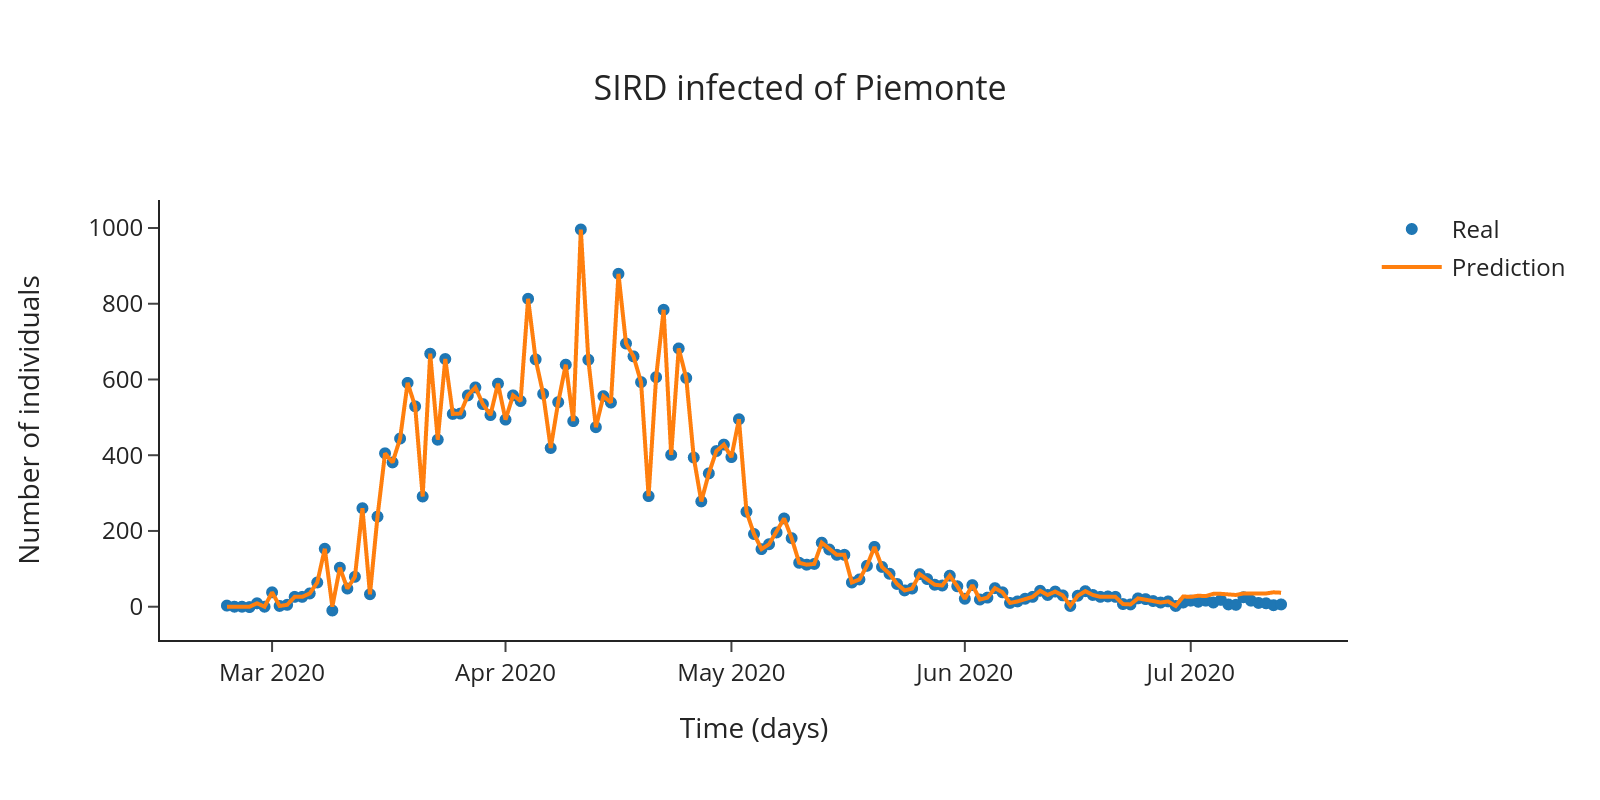

In [65]:
general_plot(t=real_df['data'],
             title='SIRD infected of ' + regione,
             data=[real_df['nuovi_positivi'].values, filtered_df['nuovi_positivi'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [66]:
mean_absolute_error(real_df['nuovi_positivi'].values, filtered_df['nuovi_positivi'].values), mean_squared_error(real_df['nuovi_positivi'].values, filtered_df['nuovi_positivi'].values)

(2.141843971631206, 48.09929078014184)

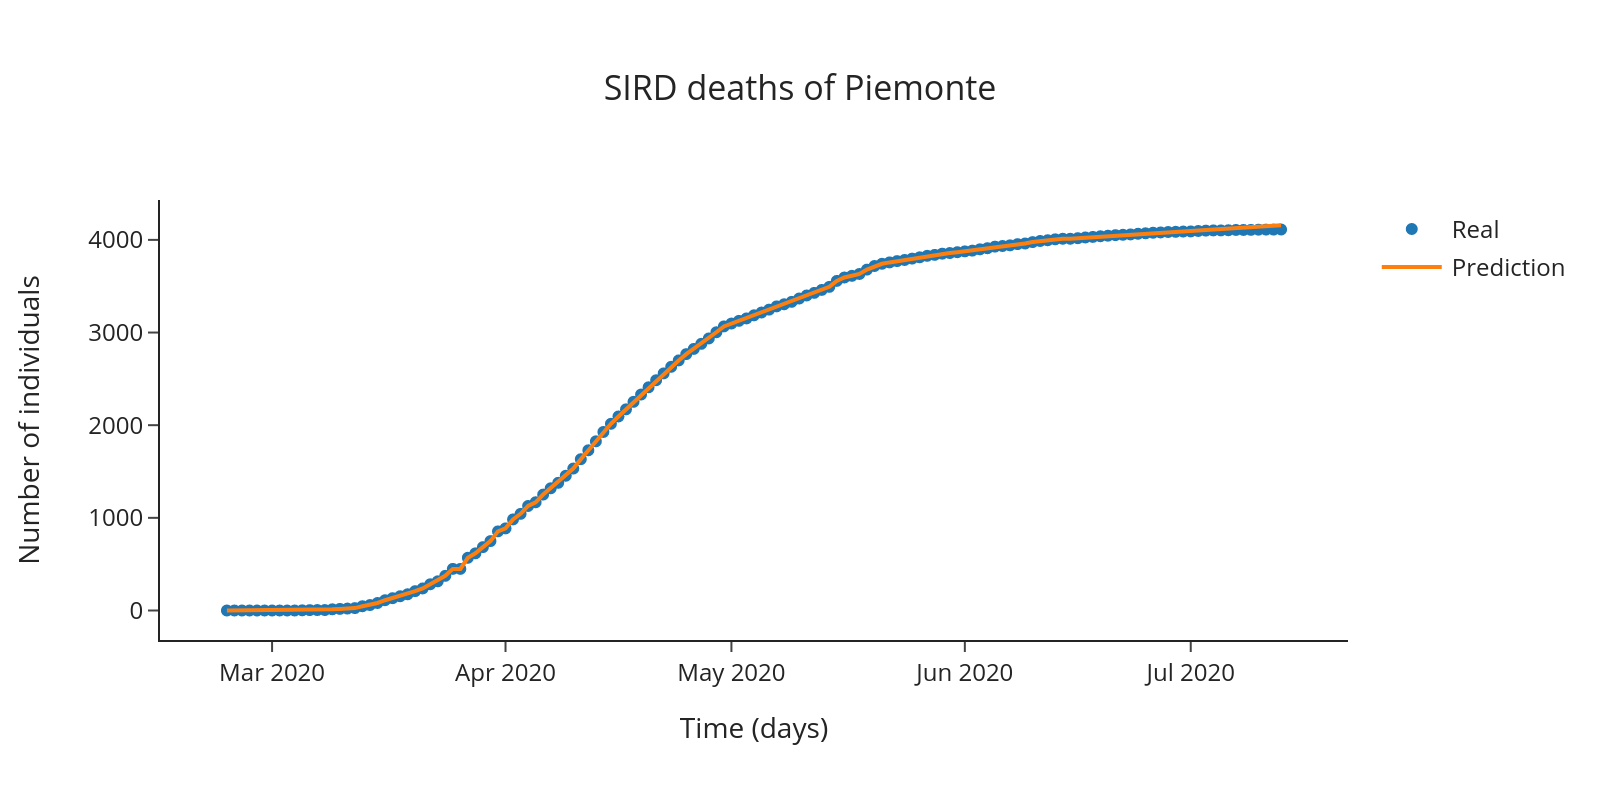

In [67]:
general_plot(t=real_df['data'],
             title='SIRD deaths of ' + regione,
             data=[real_df['deceduti'].values, filtered_df['deceduti'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [68]:
mean_absolute_error(real_df['deceduti'].values, filtered_df['deceduti'].values), mean_squared_error(real_df['deceduti'].values, filtered_df['deceduti'].values)

(1.9361702127659575, 57.51063829787234)

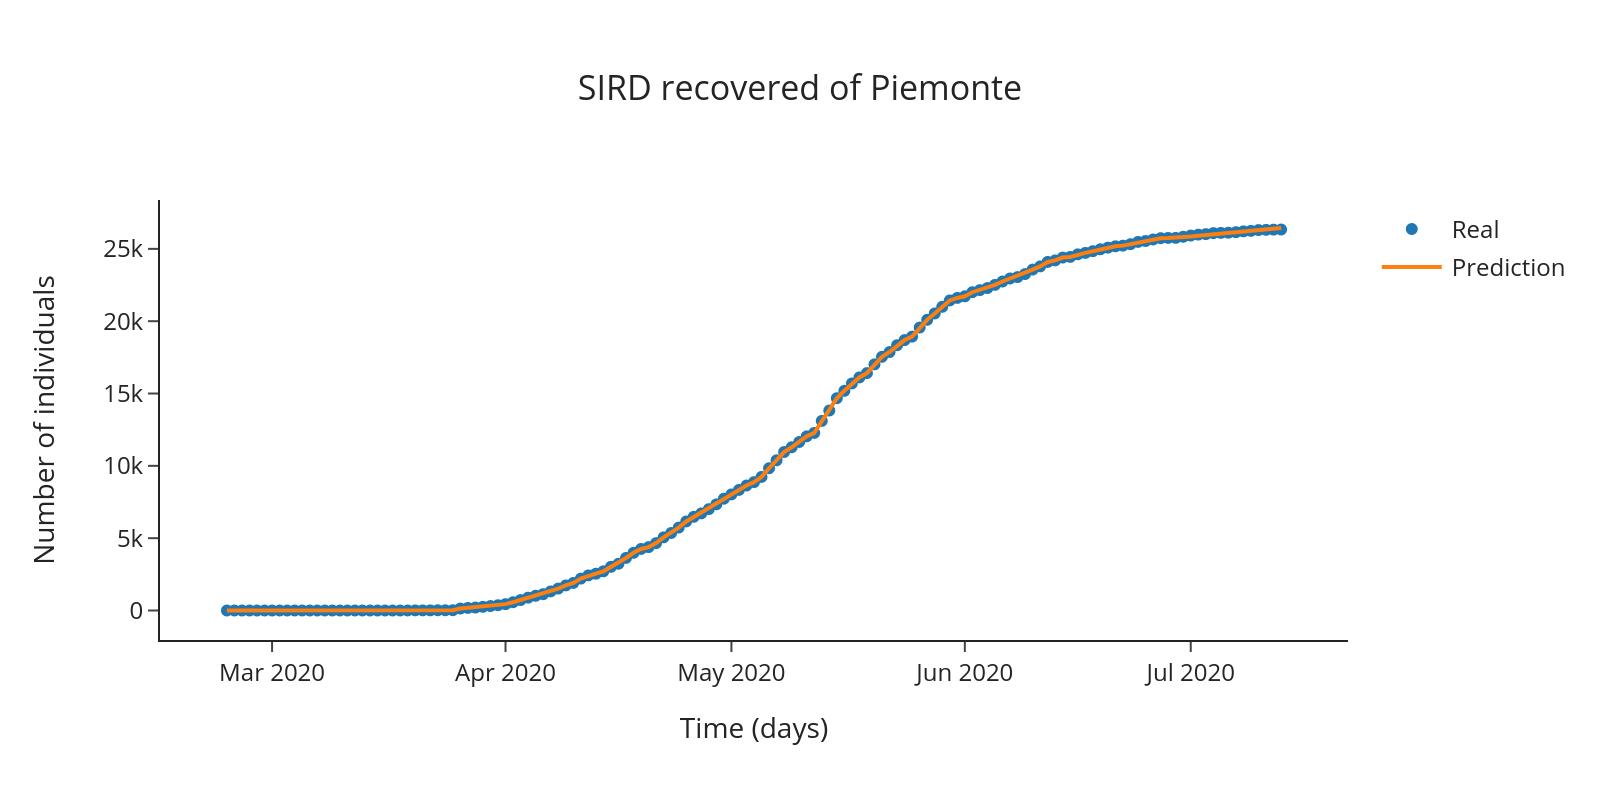

In [69]:
general_plot(t=real_df['data'],
             title='SIRD recovered of ' + regione,
             data=[real_df['dimessi_guariti'].values, filtered_df['dimessi_guariti'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [70]:
mean_absolute_error(real_df['dimessi_guariti'].values, filtered_df['dimessi_guariti'].values), mean_squared_error(real_df['dimessi_guariti'].values, filtered_df['dimessi_guariti'].values)

(3.8652482269503547, 244.9290780141844)

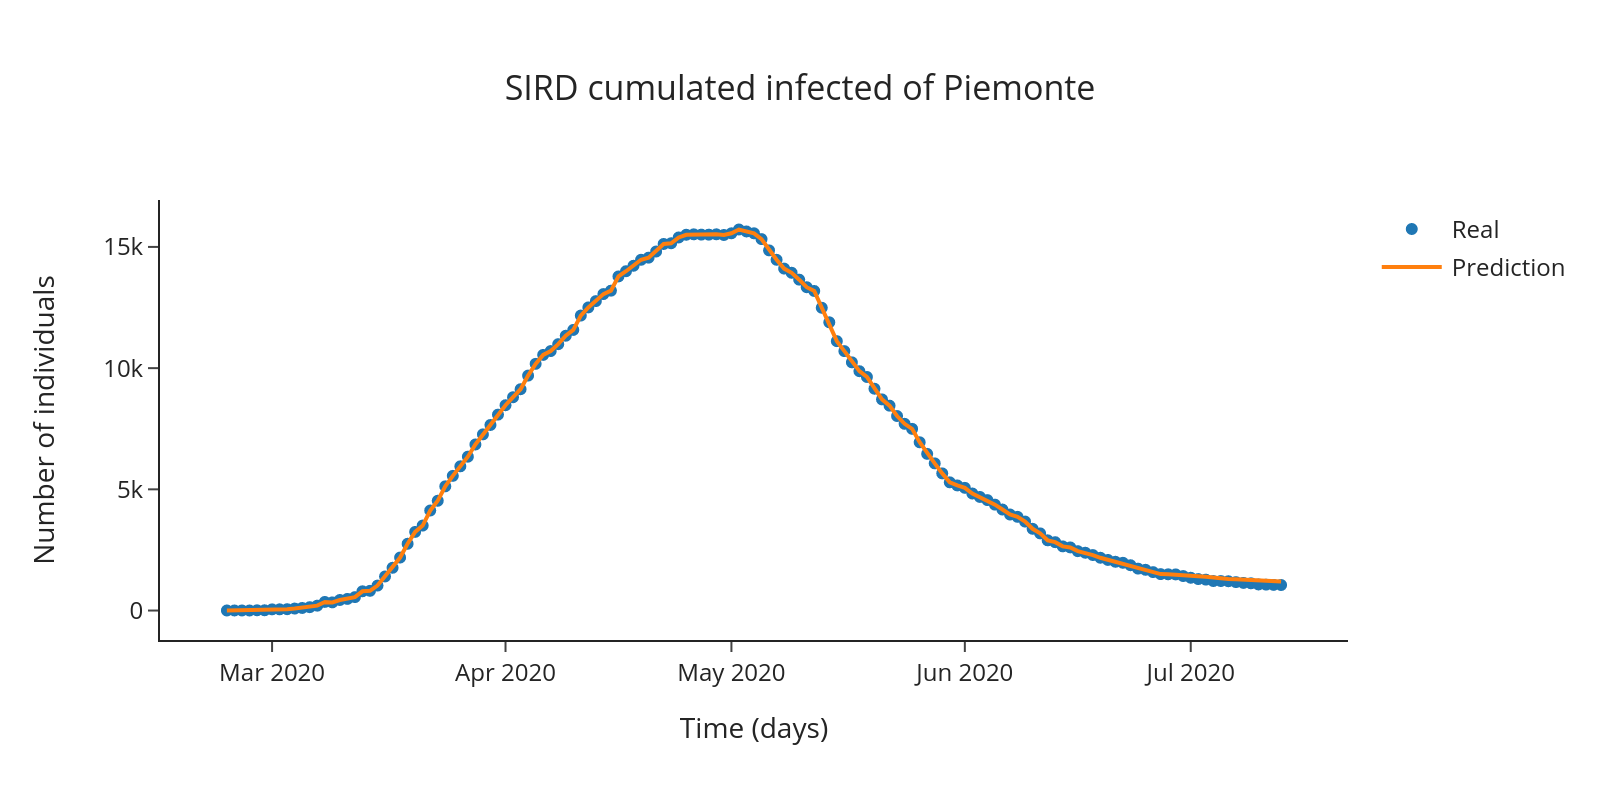

In [71]:
general_plot(t=real_df['data'],
             title='SIRD cumulated infected of ' + regione,
             data=[real_df['totale_positivi'].values, filtered_df['totale_positivi'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [72]:
mean_absolute_error(real_df['totale_positivi'].values, filtered_df['totale_positivi'].values), mean_squared_error(real_df['totale_positivi'].values, filtered_df['totale_positivi'].values)

(12.28368794326241, 1627.404255319149)

### Grid search for best no. of lags and no. of days to predict

In [5]:
from tqdm import tqdm

lags = range(5,15)
days_range = range(5,31)
data_filter = '20200630'

tot_len = len(dpc_regioni_df.denominazione_regione.unique()) * len(lags) * len(days_range)
pbar = tqdm(total=tot_len)

results = []

for regione in dpc_regioni_df.denominazione_regione.unique():
    for l in lags:
        for d in days_range:
            model = DeterministicSird(
                data_df=dpc_regioni_df,
                pop_prov_df=pop_prov_df, 
                prov_list_df=prov_list_df, 
                area=regione, 
                group_column='denominazione_regione', 
                data_column='data', 
                data_filter=data_filter, 
                lag=l, 
                days_to_predict=d)
            
            res = model.fit()

            realdf = model.real_df

            if res.shape[0] != realdf.shape[0]:
                print(regione, l, d, res.shape[0], realdf.shape[0])

            mae_tot_pos = model.mae(compart='totale_positivi')
            mse_tot_pos = model.mse(compart='totale_positivi')
            mae_deaths = model.mae(compart='deceduti')
            mse_deaths = model.mse(compart='deceduti')
            mae_rec = model.mae(compart='dimessi_guariti')
            mse_rec = model.mse(compart='dimessi_guariti')

            mae_avg = np.mean([mae_tot_pos, mae_deaths, mae_rec])
            mse_avg = np.mean([mse_tot_pos, mse_deaths, mse_rec])

            results.append([
                regione,
                l,
                d,
                data_filter,
                mae_avg,
                mse_avg,
                mae_tot_pos,
                mse_tot_pos,
                mae_deaths,
                mse_deaths,
                mae_rec,
                mse_rec])

            pbar.update(1)

pbar.close()

100%|██████████| 3200/3200 [04:03<00:00, 13.14it/s]


In [14]:
results_df = pd.DataFrame.from_records(results, columns=[
    'region',
    'lag',
    'days_to_predict',
    'train_last_date',
    'avg_mae',
    'avg_mse',
    'mae_tot_pos',
    'mse_tot_pos',
    'mae_deaths',
    'mse_deaths',
    'mae_recovered',
    'mse_recovered'])

In [19]:
results_df

,region,lag,days_to_predict,train_last_date,avg_mae,avg_mse,mae_tot_pos,mse_tot_pos,mae_deaths,mse_deaths,mae_recovered,mse_recovered
0,Abruzzo,5,5,20200630,2.118687,177.093434,3.431818,312.780303,0.053030,0.113636,2.871212,218.386364
1,Abruzzo,5,6,20200630,2.483709,204.097744,4.060150,367.338346,0.082707,0.233083,3.308271,244.721805
2,Abruzzo,5,7,20200630,2.855721,232.985075,4.731343,430.537313,0.119403,0.417910,3.716418,268.000000
3,Abruzzo,5,8,20200630,3.224691,262.483951,5.429630,499.948148,0.162963,0.681481,4.081481,286.822222
4,Abruzzo,5,9,20200630,3.615196,296.678922,6.191176,583.632353,0.213235,1.036765,4.441176,305.367647
...,...,...,...,...,...,...,...,...,...,...,...,...
3035,Veneto,14,26,20200630,13.880174,3430.206972,29.261438,9488.176471,3.117647,64.895425,9.261438,737.549020
3036,Veneto,14,27,20200630,15.214286,4005.088745,32.389610,11122.155844,3.285714,69.935065,9.967532,823.175325
3037,Veneto,14,28,20200630,16.587097,4622.655914,35.612903,12876.361290,3.445161,74.541935,10.703226,917.064516
3038,Veneto,14,29,20200630,18.017094,5287.017094,38.929487,14754.134615,3.628205,80.628205,11.493590,1026.288462


In [16]:
results_df.replace(0, np.nan, inplace=True)

In [20]:
results_df.groupby('region').agg(['min'])

,lag,days_to_predict,avg_mae,avg_mse,mae_tot_pos,mse_tot_pos,mae_deaths,mse_deaths,mae_recovered,mse_recovered
,min,min,min,min,min,min,min,min,min,min
region,,,,,,,,,,
Abruzzo,5,5,1.936869,146.967172,2.772727,204.636364,0.053030,0.113636,2.871212,218.386364
Basilicata,5,5,0.017677,0.017677,0.030303,0.030303,0.006803,0.006803,0.022727,0.022727
Calabria,5,5,0.025253,0.045455,0.007463,0.007463,NaN,NaN,0.045455,0.090909
Campania,5,5,0.320707,6.118687,0.818182,17.893939,0.037879,0.037879,0.083333,0.265152
Emilia-Romagna,5,5,0.828283,36.025253,1.219697,69.871212,0.166667,0.772727,1.015152,36.515152
Friuli Venezia Giulia,5,5,0.714646,22.876263,1.174242,41.734848,NaN,NaN,0.954545,26.212121
Lazio,5,5,0.434343,12.661616,0.560606,21.787879,0.014925,0.014925,0.704545,16.143939
Liguria,5,5,0.179293,1.267677,0.075758,0.257576,0.151515,0.742424,0.204545,1.386364


In [21]:
results_df.to_csv("../results/sirddet_region.csv", index=False)

### Provincial grid search for lags and days to predict

In [5]:
from tqdm import tqdm

lags = range(5,15)
days_range = range(15,31)
data_filter = '20200630'

tot_len = len(covidpro_df.Province.unique()) * len(lags) * len(days_range)
pbar = tqdm(total=tot_len)

results = []

for prov in covidpro_df.Province.unique():
    for l in lags:
        for d in days_range:
            model = DeterministicSird(
                data_df=covidpro_df,
                pop_prov_df=pop_prov_df, 
                prov_list_df=prov_list_df, 
                area=prov, 
                group_column='Province', 
                data_column='Date', 
                data_filter=data_filter, 
                lag=l, 
                days_to_predict=d,
                is_regional=False,
                pcm_data=dpc_regioni_df)
            
            try:
                res = model.fit()

                realdf = model.real_df

                if res.shape[0] != realdf.shape[0]:
                    print(prov, l, d, res.shape[0], realdf.shape[0])

                mae_tot_pos = model.mae(compart='totale_positivi')
                mse_tot_pos = model.mse(compart='totale_positivi')
                mae_deaths = model.mae(compart='deceduti')
                mse_deaths = model.mse(compart='deceduti')
                mae_rec = model.mae(compart='dimessi_guariti')
                mse_rec = model.mse(compart='dimessi_guariti')

                mae_avg = np.mean([mae_tot_pos, mae_deaths, mae_rec])
                mse_avg = np.mean([mse_tot_pos, mse_deaths, mse_rec])

                results.append([
                    prov,
                    l,
                    d,
                    data_filter,
                    mae_avg,
                    mse_avg,
                    mae_tot_pos,
                    mse_tot_pos,
                    mae_deaths,
                    mse_deaths,
                    mae_rec,
                    mse_rec])
            
            except Exception as e:
                print(prov, l, d)
                print(e)
                results.append([
                    prov,
                    l,
                    d,
                    data_filter,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0])

            pbar.update(1)

pbar.close()

 21%|██▏       | 3106/14560 [03:54<14:20, 13.32it/s]Chieti 8 30 156 156
Cannot convert non-finite values (NA or inf) to integer
 64%|██████▍   | 9389/14560 [12:14<06:33, 13.13it/s]Pistoia 11 26 152 152
Cannot convert non-finite values (NA or inf) to integer
Pistoia 11 27 152 152
Cannot convert non-finite values (NA or inf) to integer
Pistoia 11 28 152 152
Cannot convert non-finite values (NA or inf) to integer
 65%|██████▍   | 9393/14560 [12:15<06:47, 12.69it/s]Pistoia 11 29 152 152
Cannot convert non-finite values (NA or inf) to integer
Pistoia 11 30 152 152
Cannot convert non-finite values (NA or inf) to integer
 65%|██████▍   | 9405/14560 [12:16<06:38, 12.92it/s]Pistoia 12 25 151 151
Cannot convert non-finite values (NA or inf) to integer
Pistoia 12 26 151 151
Cannot convert non-finite values (NA or inf) to integer
Pistoia 12 27 151 151
Cannot convert non-finite values (NA or inf) to integer
 65%|██████▍   | 9407/14560 [12:16<07:08, 12.01it/s]Pistoia 12 28 151 151
Cannot convert non

In [6]:
results_df = pd.DataFrame.from_records(results, columns=[
    'province',
    'lag',
    'days_to_predict',
    'train_last_date',
    'avg_mae',
    'avg_mse',
    'mae_tot_pos',
    'mse_tot_pos',
    'mae_deaths',
    'mse_deaths',
    'mae_recovered',
    'mse_recovered'])

In [12]:
results_df

,province,lag,days_to_predict,train_last_date,avg_mae,avg_mse,mae_tot_pos,mse_tot_pos,mae_deaths,mse_deaths,mae_recovered,mse_recovered
0,Agrigento,5,5,20200630,0.313131,0.225770,0.480507,0.358012,NaN,NaN,0.458887,0.319299
1,Agrigento,5,6,20200630,0.315789,0.230153,0.487883,0.371381,NaN,NaN,0.459485,0.319079
2,Agrigento,5,7,20200630,0.320896,0.239721,0.496448,0.388572,NaN,NaN,0.466239,0.330591
3,Agrigento,5,8,20200630,0.325926,0.249206,0.505169,0.406446,NaN,NaN,0.472609,0.341171
4,Agrigento,5,9,20200630,0.330882,0.259049,0.509814,0.412961,NaN,NaN,0.482833,0.364185
...,...,...,...,...,...,...,...,...,...,...,...,...
14555,Viterbo,14,26,20200630,5.775599,419.457370,8.629768,658.381501,NaN,NaN,8.697030,599.990609
14556,Viterbo,14,27,20200630,6.292208,487.807799,9.442838,770.429821,NaN,NaN,9.433786,692.993576
14557,Viterbo,14,28,20200630,6.862366,573.014560,10.423526,933.626700,NaN,NaN,10.163571,785.416980
14558,Viterbo,14,29,20200630,7.457265,665.311084,11.381244,1091.390949,NaN,NaN,10.990551,904.542304


In [8]:
results_df.replace(0, np.nan, inplace=True)

In [11]:
results_df.groupby('province').agg(['min'])

,lag,days_to_predict,avg_mae,avg_mse,mae_tot_pos,mse_tot_pos,mae_deaths,mse_deaths,mae_recovered,mse_recovered
,min,min,min,min,min,min,min,min,min,min
province,,,,,,,,,,
Agrigento,5,5,0.311106,0.223745,0.480507,0.358012,NaN,NaN,0.451282,0.309612
Alessandria,5,5,0.590241,4.692198,0.863751,6.565015,0.022059,0.022059,0.846367,6.526906
Ancona,5,5,0.426265,1.470590,0.602994,1.464260,NaN,NaN,0.645496,2.392494
Aosta,5,5,0.025253,0.025253,0.045455,0.045455,0.022727,0.022727,0.028986,0.028986
Arezzo,5,5,0.322758,0.220317,0.513080,0.353638,0.007576,0.007576,0.440042,0.287650
...,...,...,...,...,...,...,...,...,...,...
Vercelli,5,5,0.391314,0.862030,0.521279,1.013505,0.030303,0.060606,0.614785,1.402028
Verona,5,5,0.404493,0.626899,0.576600,0.852278,0.060606,0.121212,0.576273,0.872536


In [13]:
results_df.to_csv("../results/sirddet_province.csv", index=False)

In [5]:
results_df = pd.read_csv("../results/sirddet_province.csv")

In [6]:
plot_df = results_df.loc[(results_df.province == "Firenze") & (results_df.days_to_predict == 14)]
plot_df.rename(columns={"lag": "Lag", "mae_tot_pos": "MAE", "days_to_predict": "Days to predict"}, inplace=True)

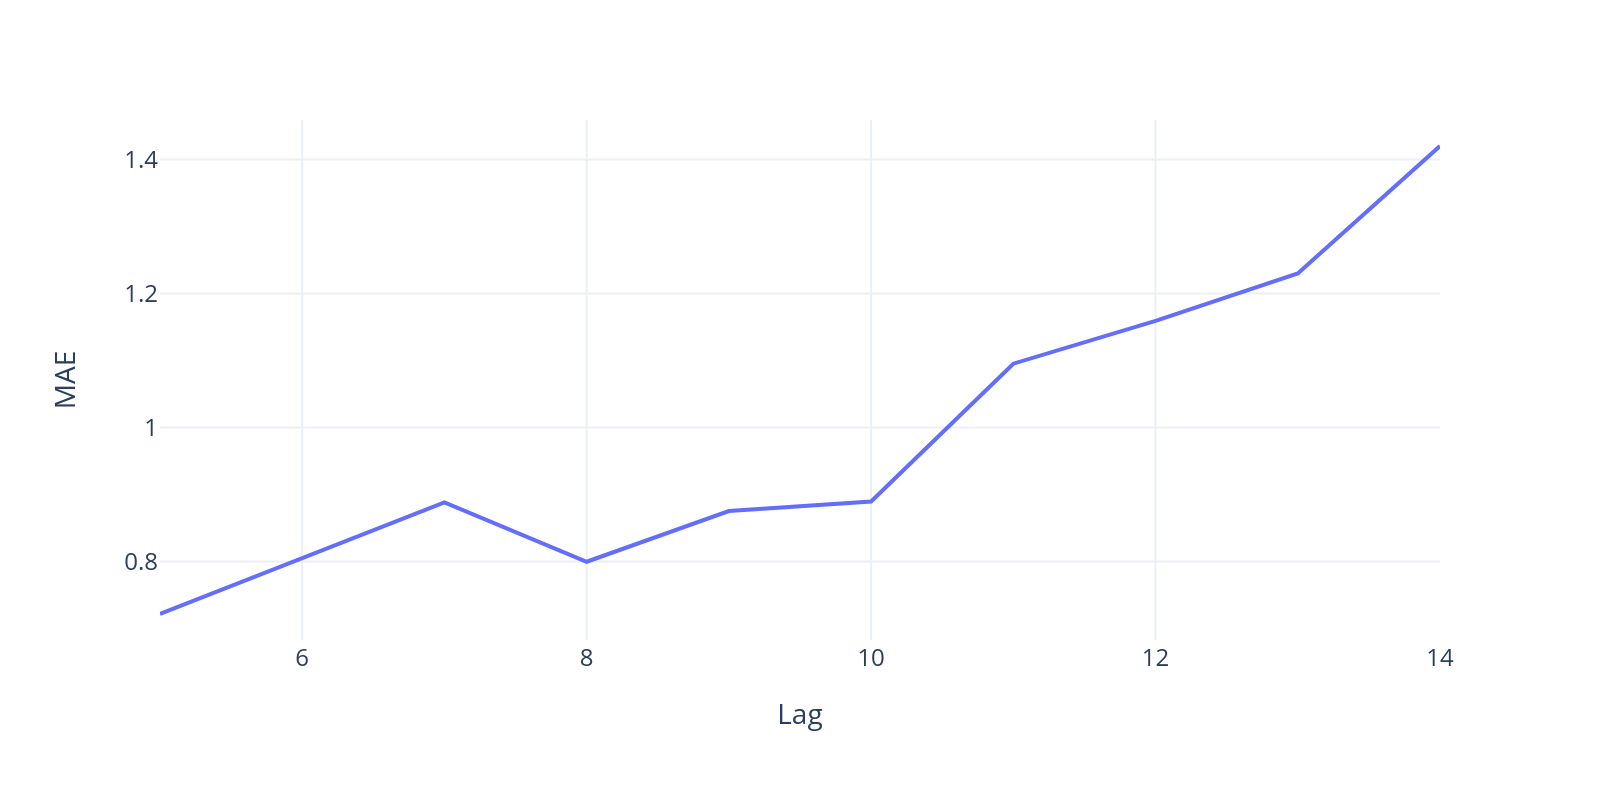

In [9]:
from IPython.display import Image

Image(plot_df.plot(x='Lag', y='MAE', backend="plotly", template="plotly_white").to_image(format="png", width=800, height=400, scale=2))

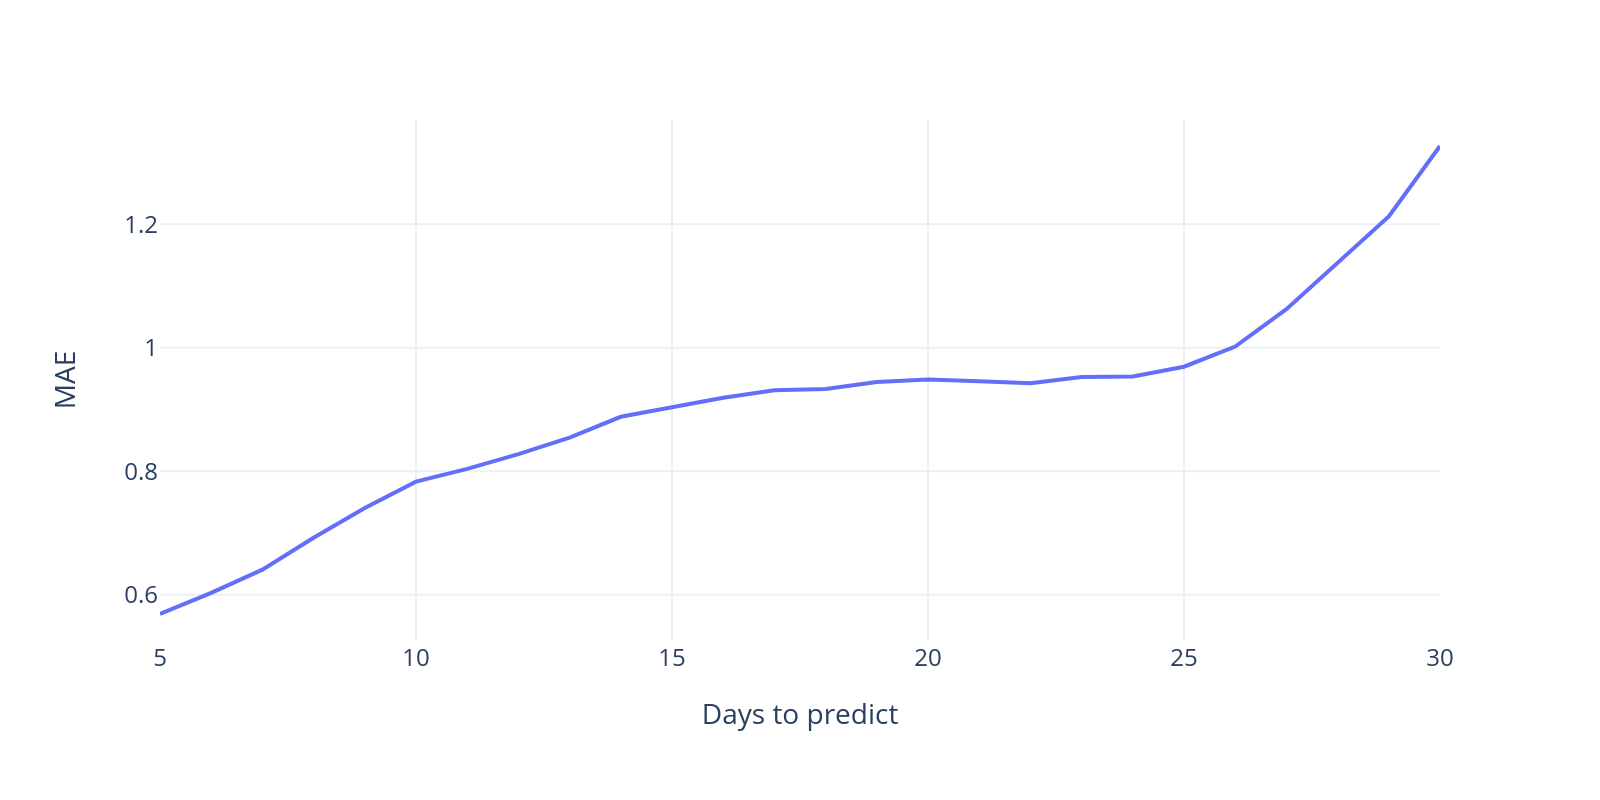

In [10]:
plot_df = results_df.loc[(results_df.province == "Firenze") & (results_df.lag == 7)]
plot_df.rename(columns={"lag": "Lag", "mae_tot_pos": "MAE", "days_to_predict": "Days to predict"}, inplace=True)
Image(plot_df.plot(x='Days to predict', y='MAE', backend="plotly", template="plotly_white").to_image(format="png", width=800, height=400, scale=2))

In [11]:
plot_df = results_df.loc[(results_df.province == "Firenze"), ["lag", "days_to_predict", "mae_tot_pos"]]
plot_df.rename(columns={"lag": "Lag", "mae_tot_pos": "MAE", "days_to_predict": "Days to predict"}, inplace=True)

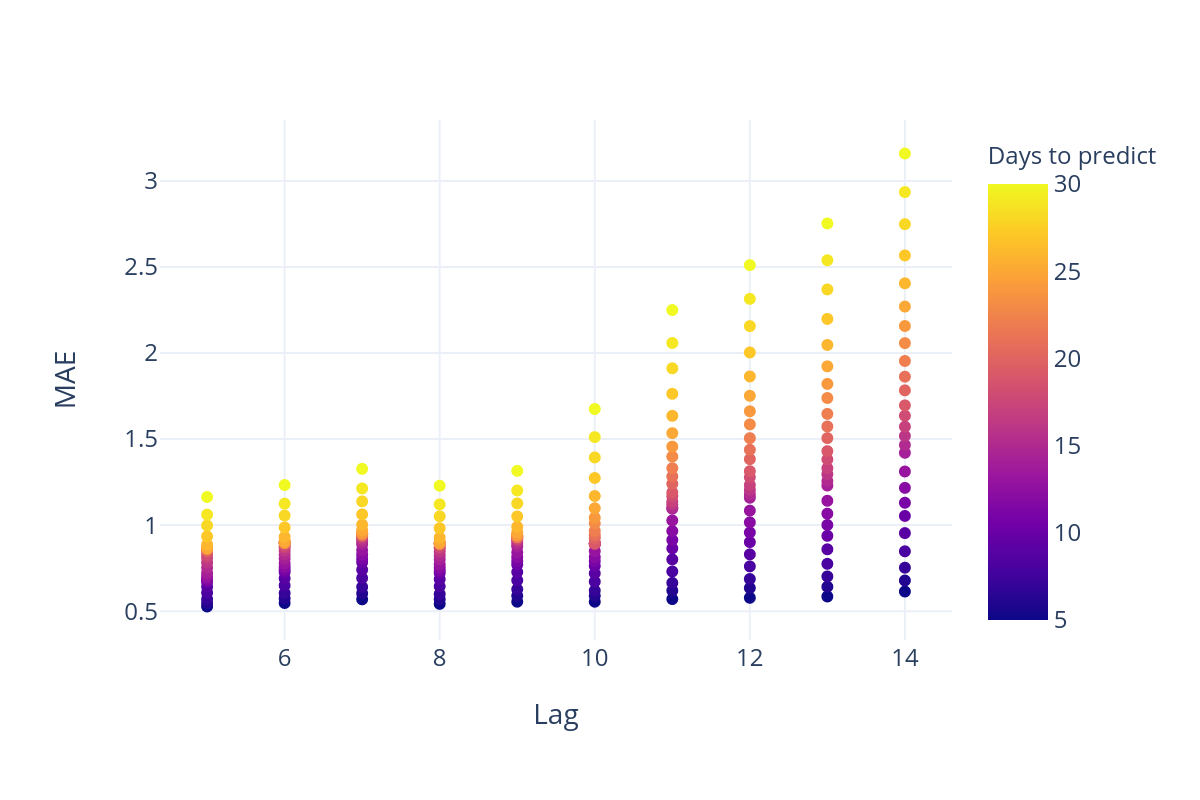

In [13]:
import plotly.express as px

fig = px.scatter(plot_df, x="Lag", y="MAE", color='Days to predict', template='plotly_white')
Image(fig.to_image(format="png", width=600, height=400, scale=2))